# Project: 모델 바꿔보기

## STEP 0: Dataset & StackedHourglass Network

In [12]:
import io, json, os, math, time

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization

# import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'ckpt')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')

### Data

In [13]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps


    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)


In [14]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

### StackedHourglass Network

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

### Training

In [16]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate, 
                 model_name):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model
        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        self.history = {'loss':[], 'val_loss':[], 'lr':[]} # 히스토리 저장용
        self.model_name = model_name # 저장용 모델명

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        # SBL과 호환성을 위해 추가
        if not isinstance(outputs, (list, tuple)):
            outputs = [outputs]
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            epoch_start_time = time.time() # 에포크 시작 시간 기록
            self.lr_decay()
            self.history['lr'].append(self.current_learning_rate) # LR 저장
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            self.history['loss'].append(train_loss.numpy()) # loss 저장
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            self.history['val_loss'].append(val_loss.numpy()) # val_loss 저장
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            epoch_end_time = time.time() # 에포크 종료 시간 기록
            epoch_duration = epoch_end_time - epoch_start_time # 소요 시간 계산
            # 시간 출력
            print('Epoch {} finished in {:.2f} seconds'.format(epoch, epoch_duration))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model, self.history # 히스토리 반환

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model_name,
                                                                       epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))
        print("="*77, "\n")
        
def train(epochs, learning_rate, num_heatmap, batch_size,
          train_tfrecords, val_tfrecords, model_builder):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = model_builder(IMAGE_SHAPE, num_heatmap)
        if model_builder == StackedHourglassNetwork:
            model_name = "SHG"
        elif model_builder == Simplebaseline:
            model_name = "SBL"

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate, model_name=model_name)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [6]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

In [7]:
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file, training_history = train(epochs, learning_rate, num_heatmap,
                                          batch_size, train_tfrecords, val_tfrecords,
                                          StackedHourglassNetwork)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.69303417 epoch total loss 2.69303417
Trained batch 2 batch loss 2.52136111 epoch total loss 2.60719776
Trained batch 3 batch loss 2.42929459 epoch total loss 2.54789662
Trained batch 4 batch loss 2.17910671 epoch total loss 2.45569921
Trained batch 5 batch loss 2.32510448 epoch total loss 2.42958021
Trained batch 6 batch loss 2.3674171 epoch total loss 2.41921973
Trained batch 7 batch loss 2.15203667 epoch total loss 2.38105059
Trained batch 8 batch loss 1.9844439 epoch total loss 2.33147478
Trained batch 9 batch loss 1.89343131 epoch total loss 2.2828033
Trained batch 10 batch loss 1.94633412 epoch total loss 2.24915648
Trained batch 11 batch loss 2.03450251 epoch total loss 2.22964239
Trained batch 12 batch loss 1.93882143 epoch total loss 2.20540738
Trained batch 13 batch loss 2.05162215 epoch total loss 2.19357777
Trained batch 14 batch loss 2.15729952 epoch total loss 2.19098639
Trained batch 15 batch loss 1.98259568 epoc

Trained batch 124 batch loss 1.68437397 epoch total loss 1.82910371
Trained batch 125 batch loss 1.70587468 epoch total loss 1.82811785
Trained batch 126 batch loss 1.66180658 epoch total loss 1.82679784
Trained batch 127 batch loss 1.75419521 epoch total loss 1.82622623
Trained batch 128 batch loss 1.74727869 epoch total loss 1.82560945
Trained batch 129 batch loss 1.66540432 epoch total loss 1.82436752
Trained batch 130 batch loss 1.69918418 epoch total loss 1.82340467
Trained batch 131 batch loss 1.77007842 epoch total loss 1.82299757
Trained batch 132 batch loss 1.55179882 epoch total loss 1.82094312
Trained batch 133 batch loss 1.61467481 epoch total loss 1.8193922
Trained batch 134 batch loss 1.68764114 epoch total loss 1.81840897
Trained batch 135 batch loss 1.65765941 epoch total loss 1.81721818
Trained batch 136 batch loss 1.60518968 epoch total loss 1.81565917
Trained batch 137 batch loss 1.69986081 epoch total loss 1.81481385
Trained batch 138 batch loss 1.68258488 epoch tot

Trained batch 245 batch loss 1.579831 epoch total loss 1.73972845
Trained batch 246 batch loss 1.47202861 epoch total loss 1.73864019
Trained batch 247 batch loss 1.50650704 epoch total loss 1.73770034
Trained batch 248 batch loss 1.53990042 epoch total loss 1.73690271
Trained batch 249 batch loss 1.69436061 epoch total loss 1.73673189
Trained batch 250 batch loss 1.69425428 epoch total loss 1.73656189
Trained batch 251 batch loss 1.60992837 epoch total loss 1.7360574
Trained batch 252 batch loss 1.46389651 epoch total loss 1.73497736
Trained batch 253 batch loss 1.55570853 epoch total loss 1.73426878
Trained batch 254 batch loss 1.61292267 epoch total loss 1.73379099
Trained batch 255 batch loss 1.62393391 epoch total loss 1.73336017
Trained batch 256 batch loss 1.63877022 epoch total loss 1.73299062
Trained batch 257 batch loss 1.57291663 epoch total loss 1.73236775
Trained batch 258 batch loss 1.5613786 epoch total loss 1.73170495
Trained batch 259 batch loss 1.6029644 epoch total l

Trained batch 367 batch loss 1.55751014 epoch total loss 1.69128072
Trained batch 368 batch loss 1.6359098 epoch total loss 1.69113028
Trained batch 369 batch loss 1.55483258 epoch total loss 1.69076085
Trained batch 370 batch loss 1.45278907 epoch total loss 1.6901176
Trained batch 371 batch loss 1.49757612 epoch total loss 1.68959856
Trained batch 372 batch loss 1.58274388 epoch total loss 1.68931139
Trained batch 373 batch loss 1.61578608 epoch total loss 1.68911421
Trained batch 374 batch loss 1.60609484 epoch total loss 1.68889225
Trained batch 375 batch loss 1.58835638 epoch total loss 1.68862414
Trained batch 376 batch loss 1.4743073 epoch total loss 1.6880542
Trained batch 377 batch loss 1.49908566 epoch total loss 1.68755293
Trained batch 378 batch loss 1.62908721 epoch total loss 1.68739831
Trained batch 379 batch loss 1.64039719 epoch total loss 1.68727422
Trained batch 380 batch loss 1.61315691 epoch total loss 1.68707919
Trained batch 381 batch loss 1.52396834 epoch total 

Trained batch 488 batch loss 1.58166933 epoch total loss 1.65796494
Trained batch 489 batch loss 1.5931797 epoch total loss 1.6578325
Trained batch 490 batch loss 1.49708128 epoch total loss 1.65750444
Trained batch 491 batch loss 1.67522883 epoch total loss 1.65754056
Trained batch 492 batch loss 1.51309812 epoch total loss 1.65724707
Trained batch 493 batch loss 1.63898766 epoch total loss 1.65721
Trained batch 494 batch loss 1.45957935 epoch total loss 1.65680993
Trained batch 495 batch loss 1.47840869 epoch total loss 1.65644956
Trained batch 496 batch loss 1.58265305 epoch total loss 1.65630066
Trained batch 497 batch loss 1.59765279 epoch total loss 1.65618265
Trained batch 498 batch loss 1.64836717 epoch total loss 1.65616703
Trained batch 499 batch loss 1.63129663 epoch total loss 1.6561172
Trained batch 500 batch loss 1.71661687 epoch total loss 1.6562382
Trained batch 501 batch loss 1.67215014 epoch total loss 1.65627
Trained batch 502 batch loss 1.64651489 epoch total loss 1

Trained batch 610 batch loss 1.53047848 epoch total loss 1.63908303
Trained batch 611 batch loss 1.62618029 epoch total loss 1.63906181
Trained batch 612 batch loss 1.62473416 epoch total loss 1.63903844
Trained batch 613 batch loss 1.623191 epoch total loss 1.63901258
Trained batch 614 batch loss 1.46758139 epoch total loss 1.63873339
Trained batch 615 batch loss 1.57354331 epoch total loss 1.63862741
Trained batch 616 batch loss 1.50328934 epoch total loss 1.63840771
Trained batch 617 batch loss 1.49652016 epoch total loss 1.63817775
Trained batch 618 batch loss 1.5622195 epoch total loss 1.63805485
Trained batch 619 batch loss 1.61919236 epoch total loss 1.63802433
Trained batch 620 batch loss 1.62345469 epoch total loss 1.63800085
Trained batch 621 batch loss 1.59673727 epoch total loss 1.63793445
Trained batch 622 batch loss 1.59743857 epoch total loss 1.63786924
Trained batch 623 batch loss 1.61374426 epoch total loss 1.63783062
Trained batch 624 batch loss 1.57192385 epoch total

Trained batch 731 batch loss 1.48634195 epoch total loss 1.62519717
Trained batch 732 batch loss 1.46073437 epoch total loss 1.62497246
Trained batch 733 batch loss 1.48568797 epoch total loss 1.62478256
Trained batch 734 batch loss 1.44827414 epoch total loss 1.624542
Trained batch 735 batch loss 1.47383106 epoch total loss 1.62433696
Trained batch 736 batch loss 1.4411552 epoch total loss 1.62408817
Trained batch 737 batch loss 1.43088746 epoch total loss 1.62382603
Trained batch 738 batch loss 1.47286892 epoch total loss 1.62362146
Trained batch 739 batch loss 1.44931793 epoch total loss 1.62338567
Trained batch 740 batch loss 1.44782686 epoch total loss 1.62314844
Trained batch 741 batch loss 1.46905971 epoch total loss 1.62294066
Trained batch 742 batch loss 1.54238331 epoch total loss 1.62283206
Trained batch 743 batch loss 1.57632482 epoch total loss 1.62276936
Trained batch 744 batch loss 1.56809354 epoch total loss 1.62269592
Trained batch 745 batch loss 1.51833248 epoch total

Trained batch 852 batch loss 1.42488241 epoch total loss 1.60742056
Trained batch 853 batch loss 1.52991319 epoch total loss 1.60732973
Trained batch 854 batch loss 1.56708026 epoch total loss 1.60728264
Trained batch 855 batch loss 1.63219213 epoch total loss 1.60731184
Trained batch 856 batch loss 1.76735568 epoch total loss 1.60749876
Trained batch 857 batch loss 1.58083987 epoch total loss 1.60746765
Trained batch 858 batch loss 1.56182814 epoch total loss 1.60741436
Trained batch 859 batch loss 1.4787817 epoch total loss 1.60726452
Trained batch 860 batch loss 1.43715608 epoch total loss 1.60706675
Trained batch 861 batch loss 1.53055751 epoch total loss 1.60697782
Trained batch 862 batch loss 1.49205375 epoch total loss 1.60684454
Trained batch 863 batch loss 1.57739103 epoch total loss 1.60681045
Trained batch 864 batch loss 1.51553464 epoch total loss 1.60670471
Trained batch 865 batch loss 1.55638778 epoch total loss 1.60664654
Trained batch 866 batch loss 1.48413992 epoch tot

Trained batch 973 batch loss 1.4587357 epoch total loss 1.59036052
Trained batch 974 batch loss 1.6545831 epoch total loss 1.59042645
Trained batch 975 batch loss 1.73712218 epoch total loss 1.59057689
Trained batch 976 batch loss 1.64977169 epoch total loss 1.59063756
Trained batch 977 batch loss 1.45657051 epoch total loss 1.59050035
Trained batch 978 batch loss 1.38903105 epoch total loss 1.59029436
Trained batch 979 batch loss 1.46956563 epoch total loss 1.5901711
Trained batch 980 batch loss 1.46205771 epoch total loss 1.59004033
Trained batch 981 batch loss 1.45922732 epoch total loss 1.58990693
Trained batch 982 batch loss 1.37599528 epoch total loss 1.58968914
Trained batch 983 batch loss 1.39901161 epoch total loss 1.58949518
Trained batch 984 batch loss 1.46067619 epoch total loss 1.58936429
Trained batch 985 batch loss 1.44348216 epoch total loss 1.58921611
Trained batch 986 batch loss 1.53241289 epoch total loss 1.58915865
Trained batch 987 batch loss 1.48160172 epoch total

Trained batch 1093 batch loss 1.48760545 epoch total loss 1.57906282
Trained batch 1094 batch loss 1.50882864 epoch total loss 1.57899857
Trained batch 1095 batch loss 1.51360774 epoch total loss 1.57893884
Trained batch 1096 batch loss 1.41029477 epoch total loss 1.57878494
Trained batch 1097 batch loss 1.39356065 epoch total loss 1.57861602
Trained batch 1098 batch loss 1.45106208 epoch total loss 1.57849991
Trained batch 1099 batch loss 1.48120344 epoch total loss 1.57841134
Trained batch 1100 batch loss 1.44807541 epoch total loss 1.57829285
Trained batch 1101 batch loss 1.4785862 epoch total loss 1.57820237
Trained batch 1102 batch loss 1.48522294 epoch total loss 1.57811797
Trained batch 1103 batch loss 1.45360732 epoch total loss 1.57800519
Trained batch 1104 batch loss 1.52731562 epoch total loss 1.5779593
Trained batch 1105 batch loss 1.4872582 epoch total loss 1.57787716
Trained batch 1106 batch loss 1.48576868 epoch total loss 1.57779384
Trained batch 1107 batch loss 1.45320

Trained batch 1213 batch loss 1.44271183 epoch total loss 1.56735611
Trained batch 1214 batch loss 1.43713498 epoch total loss 1.56724882
Trained batch 1215 batch loss 1.46781564 epoch total loss 1.56716704
Trained batch 1216 batch loss 1.3260169 epoch total loss 1.56696868
Trained batch 1217 batch loss 1.50955343 epoch total loss 1.56692147
Trained batch 1218 batch loss 1.52921534 epoch total loss 1.56689048
Trained batch 1219 batch loss 1.40632701 epoch total loss 1.56675887
Trained batch 1220 batch loss 1.42140675 epoch total loss 1.56663966
Trained batch 1221 batch loss 1.35426843 epoch total loss 1.56646574
Trained batch 1222 batch loss 1.46268547 epoch total loss 1.56638074
Trained batch 1223 batch loss 1.54881191 epoch total loss 1.56636643
Trained batch 1224 batch loss 1.47218132 epoch total loss 1.56628942
Trained batch 1225 batch loss 1.5418216 epoch total loss 1.56626952
Trained batch 1226 batch loss 1.39658034 epoch total loss 1.56613111
Trained batch 1227 batch loss 1.2869

Trained batch 1333 batch loss 1.5346446 epoch total loss 1.55585182
Trained batch 1334 batch loss 1.53802156 epoch total loss 1.55583847
Trained batch 1335 batch loss 1.50339508 epoch total loss 1.55579925
Trained batch 1336 batch loss 1.45381474 epoch total loss 1.55572295
Trained batch 1337 batch loss 1.55073977 epoch total loss 1.55571926
Trained batch 1338 batch loss 1.45328379 epoch total loss 1.55564272
Trained batch 1339 batch loss 1.40768731 epoch total loss 1.55553222
Trained batch 1340 batch loss 1.45939779 epoch total loss 1.55546057
Trained batch 1341 batch loss 1.41757548 epoch total loss 1.55535769
Trained batch 1342 batch loss 1.48050344 epoch total loss 1.5553019
Trained batch 1343 batch loss 1.51315761 epoch total loss 1.55527043
Trained batch 1344 batch loss 1.22725189 epoch total loss 1.55502641
Trained batch 1345 batch loss 1.37517834 epoch total loss 1.55489278
Trained batch 1346 batch loss 1.41475534 epoch total loss 1.55478871
Trained batch 1347 batch loss 1.3824

Validated batch 107 batch loss 1.37987149
Validated batch 108 batch loss 1.45495129
Validated batch 109 batch loss 1.4439218
Validated batch 110 batch loss 1.46805656
Validated batch 111 batch loss 1.55574191
Validated batch 112 batch loss 1.65177417
Validated batch 113 batch loss 1.58528256
Validated batch 114 batch loss 1.43633437
Validated batch 115 batch loss 1.3500334
Validated batch 116 batch loss 1.28893316
Validated batch 117 batch loss 1.4837544
Validated batch 118 batch loss 1.48619199
Validated batch 119 batch loss 1.40903413
Validated batch 120 batch loss 1.45550346
Validated batch 121 batch loss 1.57630897
Validated batch 122 batch loss 1.3465569
Validated batch 123 batch loss 1.48247194
Validated batch 124 batch loss 1.43393648
Validated batch 125 batch loss 1.47741246
Validated batch 126 batch loss 1.47327626
Validated batch 127 batch loss 1.40721333
Validated batch 128 batch loss 1.23587382
Validated batch 129 batch loss 1.46297908
Validated batch 130 batch loss 1.45575

Trained batch 72 batch loss 1.49146891 epoch total loss 1.41648233
Trained batch 73 batch loss 1.4341917 epoch total loss 1.4167248
Trained batch 74 batch loss 1.48120236 epoch total loss 1.4175961
Trained batch 75 batch loss 1.46919155 epoch total loss 1.41828406
Trained batch 76 batch loss 1.48144782 epoch total loss 1.41911519
Trained batch 77 batch loss 1.4115653 epoch total loss 1.4190172
Trained batch 78 batch loss 1.3895793 epoch total loss 1.41863978
Trained batch 79 batch loss 1.49321389 epoch total loss 1.4195838
Trained batch 80 batch loss 1.38375664 epoch total loss 1.41913593
Trained batch 81 batch loss 1.28753018 epoch total loss 1.41751122
Trained batch 82 batch loss 1.50341201 epoch total loss 1.41855872
Trained batch 83 batch loss 1.45311177 epoch total loss 1.418975
Trained batch 84 batch loss 1.43679833 epoch total loss 1.41918719
Trained batch 85 batch loss 1.36046541 epoch total loss 1.41849637
Trained batch 86 batch loss 1.39080632 epoch total loss 1.41817439
Trai

Trained batch 194 batch loss 1.40823126 epoch total loss 1.43195403
Trained batch 195 batch loss 1.41862905 epoch total loss 1.43188572
Trained batch 196 batch loss 1.51790869 epoch total loss 1.43232465
Trained batch 197 batch loss 1.46821141 epoch total loss 1.43250668
Trained batch 198 batch loss 1.26103723 epoch total loss 1.43164074
Trained batch 199 batch loss 1.26813841 epoch total loss 1.43081915
Trained batch 200 batch loss 1.39036453 epoch total loss 1.43061674
Trained batch 201 batch loss 1.35833716 epoch total loss 1.4302572
Trained batch 202 batch loss 1.34580028 epoch total loss 1.42983902
Trained batch 203 batch loss 1.41848886 epoch total loss 1.42978311
Trained batch 204 batch loss 1.46186972 epoch total loss 1.42994046
Trained batch 205 batch loss 1.43181849 epoch total loss 1.42994964
Trained batch 206 batch loss 1.50542617 epoch total loss 1.43031609
Trained batch 207 batch loss 1.35733628 epoch total loss 1.42996347
Trained batch 208 batch loss 1.46359909 epoch tot

Trained batch 316 batch loss 1.45619166 epoch total loss 1.42379737
Trained batch 317 batch loss 1.44539189 epoch total loss 1.42386544
Trained batch 318 batch loss 1.30017769 epoch total loss 1.42347646
Trained batch 319 batch loss 1.34690928 epoch total loss 1.42323649
Trained batch 320 batch loss 1.32523382 epoch total loss 1.42293024
Trained batch 321 batch loss 1.30315375 epoch total loss 1.42255712
Trained batch 322 batch loss 1.33708704 epoch total loss 1.42229176
Trained batch 323 batch loss 1.32261086 epoch total loss 1.42198312
Trained batch 324 batch loss 1.26383042 epoch total loss 1.42149496
Trained batch 325 batch loss 1.29547799 epoch total loss 1.42110717
Trained batch 326 batch loss 1.37834537 epoch total loss 1.42097604
Trained batch 327 batch loss 1.4569155 epoch total loss 1.42108595
Trained batch 328 batch loss 1.49860775 epoch total loss 1.42132223
Trained batch 329 batch loss 1.44960284 epoch total loss 1.4214083
Trained batch 330 batch loss 1.61854923 epoch tota

Trained batch 437 batch loss 1.2969569 epoch total loss 1.41552389
Trained batch 438 batch loss 1.31019557 epoch total loss 1.41528332
Trained batch 439 batch loss 1.40265357 epoch total loss 1.41525459
Trained batch 440 batch loss 1.28242433 epoch total loss 1.41495264
Trained batch 441 batch loss 1.36624634 epoch total loss 1.41484225
Trained batch 442 batch loss 1.48479295 epoch total loss 1.41500056
Trained batch 443 batch loss 1.36813569 epoch total loss 1.41489482
Trained batch 444 batch loss 1.45595348 epoch total loss 1.41498721
Trained batch 445 batch loss 1.26433206 epoch total loss 1.41464877
Trained batch 446 batch loss 1.24405408 epoch total loss 1.41426623
Trained batch 447 batch loss 1.38642883 epoch total loss 1.414204
Trained batch 448 batch loss 1.31810904 epoch total loss 1.41398942
Trained batch 449 batch loss 1.42019296 epoch total loss 1.41400325
Trained batch 450 batch loss 1.58128369 epoch total loss 1.41437495
Trained batch 451 batch loss 1.61163926 epoch total

Trained batch 558 batch loss 1.3135283 epoch total loss 1.41187418
Trained batch 559 batch loss 1.38542342 epoch total loss 1.41182697
Trained batch 560 batch loss 1.44130254 epoch total loss 1.41187954
Trained batch 561 batch loss 1.37140346 epoch total loss 1.4118073
Trained batch 562 batch loss 1.34816194 epoch total loss 1.41169405
Trained batch 563 batch loss 1.26042783 epoch total loss 1.41142547
Trained batch 564 batch loss 1.34672928 epoch total loss 1.41131067
Trained batch 565 batch loss 1.40558517 epoch total loss 1.41130054
Trained batch 566 batch loss 1.31571364 epoch total loss 1.41113174
Trained batch 567 batch loss 1.39555573 epoch total loss 1.41110432
Trained batch 568 batch loss 1.33270895 epoch total loss 1.41096628
Trained batch 569 batch loss 1.32325447 epoch total loss 1.41081214
Trained batch 570 batch loss 1.28782916 epoch total loss 1.41059637
Trained batch 571 batch loss 1.45095968 epoch total loss 1.41066706
Trained batch 572 batch loss 1.43692279 epoch tota

Trained batch 680 batch loss 1.28146756 epoch total loss 1.4026854
Trained batch 681 batch loss 1.38877177 epoch total loss 1.40266502
Trained batch 682 batch loss 1.45757604 epoch total loss 1.4027456
Trained batch 683 batch loss 1.45631242 epoch total loss 1.40282404
Trained batch 684 batch loss 1.4011724 epoch total loss 1.40282154
Trained batch 685 batch loss 1.40969086 epoch total loss 1.40283155
Trained batch 686 batch loss 1.44888508 epoch total loss 1.40289879
Trained batch 687 batch loss 1.39661491 epoch total loss 1.40288961
Trained batch 688 batch loss 1.36115336 epoch total loss 1.40282893
Trained batch 689 batch loss 1.28413773 epoch total loss 1.40265667
Trained batch 690 batch loss 1.35482907 epoch total loss 1.40258741
Trained batch 691 batch loss 1.42295921 epoch total loss 1.40261686
Trained batch 692 batch loss 1.38785672 epoch total loss 1.40259552
Trained batch 693 batch loss 1.25450838 epoch total loss 1.4023819
Trained batch 694 batch loss 1.13727891 epoch total 

Trained batch 801 batch loss 1.38500476 epoch total loss 1.39392304
Trained batch 802 batch loss 1.31715667 epoch total loss 1.39382732
Trained batch 803 batch loss 1.0836091 epoch total loss 1.39344096
Trained batch 804 batch loss 1.25543928 epoch total loss 1.39326942
Trained batch 805 batch loss 1.32373881 epoch total loss 1.39318299
Trained batch 806 batch loss 1.44532526 epoch total loss 1.39324772
Trained batch 807 batch loss 1.4843421 epoch total loss 1.39336061
Trained batch 808 batch loss 1.43063426 epoch total loss 1.39340675
Trained batch 809 batch loss 1.56057346 epoch total loss 1.39361334
Trained batch 810 batch loss 1.40777445 epoch total loss 1.39363074
Trained batch 811 batch loss 1.37682259 epoch total loss 1.39361012
Trained batch 812 batch loss 1.38584399 epoch total loss 1.39360058
Trained batch 813 batch loss 1.51384091 epoch total loss 1.3937484
Trained batch 814 batch loss 1.43548703 epoch total loss 1.39379978
Trained batch 815 batch loss 1.30464649 epoch total

Trained batch 923 batch loss 1.33928704 epoch total loss 1.38971519
Trained batch 924 batch loss 1.39825892 epoch total loss 1.38972449
Trained batch 925 batch loss 1.44122958 epoch total loss 1.38978028
Trained batch 926 batch loss 1.40995193 epoch total loss 1.38980198
Trained batch 927 batch loss 1.32981575 epoch total loss 1.38973737
Trained batch 928 batch loss 1.37664723 epoch total loss 1.38972318
Trained batch 929 batch loss 1.51775718 epoch total loss 1.38986087
Trained batch 930 batch loss 1.50230432 epoch total loss 1.38998187
Trained batch 931 batch loss 1.41148007 epoch total loss 1.39000499
Trained batch 932 batch loss 1.32527661 epoch total loss 1.38993549
Trained batch 933 batch loss 1.43409896 epoch total loss 1.38998282
Trained batch 934 batch loss 1.34068835 epoch total loss 1.38993013
Trained batch 935 batch loss 1.42249322 epoch total loss 1.38996494
Trained batch 936 batch loss 1.28073692 epoch total loss 1.38984823
Trained batch 937 batch loss 1.28232622 epoch to

Trained batch 1044 batch loss 1.31056499 epoch total loss 1.38413727
Trained batch 1045 batch loss 1.30368793 epoch total loss 1.38406026
Trained batch 1046 batch loss 1.26078677 epoch total loss 1.38394237
Trained batch 1047 batch loss 1.31155539 epoch total loss 1.38387322
Trained batch 1048 batch loss 1.36975837 epoch total loss 1.38385975
Trained batch 1049 batch loss 1.19469571 epoch total loss 1.38367939
Trained batch 1050 batch loss 1.16548407 epoch total loss 1.38347173
Trained batch 1051 batch loss 1.05713093 epoch total loss 1.38316119
Trained batch 1052 batch loss 1.20386481 epoch total loss 1.38299072
Trained batch 1053 batch loss 1.42450881 epoch total loss 1.38303018
Trained batch 1054 batch loss 1.44831789 epoch total loss 1.38309216
Trained batch 1055 batch loss 1.34792447 epoch total loss 1.38305879
Trained batch 1056 batch loss 1.3805604 epoch total loss 1.38305652
Trained batch 1057 batch loss 1.28819478 epoch total loss 1.38296676
Trained batch 1058 batch loss 1.259

Trained batch 1164 batch loss 1.29474306 epoch total loss 1.38106024
Trained batch 1165 batch loss 1.33130133 epoch total loss 1.38101745
Trained batch 1166 batch loss 1.23718798 epoch total loss 1.38089418
Trained batch 1167 batch loss 1.19957316 epoch total loss 1.38073874
Trained batch 1168 batch loss 1.27666092 epoch total loss 1.38064957
Trained batch 1169 batch loss 1.25989747 epoch total loss 1.38054633
Trained batch 1170 batch loss 1.30326939 epoch total loss 1.38048017
Trained batch 1171 batch loss 1.42808306 epoch total loss 1.38052094
Trained batch 1172 batch loss 1.40899384 epoch total loss 1.38054514
Trained batch 1173 batch loss 1.4018681 epoch total loss 1.38056326
Trained batch 1174 batch loss 1.39933634 epoch total loss 1.38057923
Trained batch 1175 batch loss 1.35191989 epoch total loss 1.38055491
Trained batch 1176 batch loss 1.47014844 epoch total loss 1.38063097
Trained batch 1177 batch loss 1.43574452 epoch total loss 1.38067782
Trained batch 1178 batch loss 1.295

Trained batch 1284 batch loss 1.2449441 epoch total loss 1.37752521
Trained batch 1285 batch loss 1.33798552 epoch total loss 1.37749445
Trained batch 1286 batch loss 1.3388108 epoch total loss 1.37746441
Trained batch 1287 batch loss 1.31631434 epoch total loss 1.37741697
Trained batch 1288 batch loss 1.47154844 epoch total loss 1.37749
Trained batch 1289 batch loss 1.20468938 epoch total loss 1.37735593
Trained batch 1290 batch loss 1.10099602 epoch total loss 1.37714171
Trained batch 1291 batch loss 1.13079655 epoch total loss 1.37695086
Trained batch 1292 batch loss 1.22067273 epoch total loss 1.37682986
Trained batch 1293 batch loss 1.36424637 epoch total loss 1.37682021
Trained batch 1294 batch loss 1.24560666 epoch total loss 1.37671876
Trained batch 1295 batch loss 1.38447964 epoch total loss 1.37672484
Trained batch 1296 batch loss 1.37537241 epoch total loss 1.37672377
Trained batch 1297 batch loss 1.31550097 epoch total loss 1.37667656
Trained batch 1298 batch loss 1.3760938

Validated batch 25 batch loss 1.28003263
Validated batch 26 batch loss 1.30780792
Validated batch 27 batch loss 1.29277754
Validated batch 28 batch loss 1.31981063
Validated batch 29 batch loss 1.34490514
Validated batch 30 batch loss 1.37675369
Validated batch 31 batch loss 1.30662942
Validated batch 32 batch loss 1.34277594
Validated batch 33 batch loss 1.36415374
Validated batch 34 batch loss 1.37085128
Validated batch 35 batch loss 1.36262131
Validated batch 36 batch loss 1.30196035
Validated batch 37 batch loss 1.31745124
Validated batch 38 batch loss 1.38264191
Validated batch 39 batch loss 1.33332753
Validated batch 40 batch loss 1.45813775
Validated batch 41 batch loss 1.4111371
Validated batch 42 batch loss 1.26106381
Validated batch 43 batch loss 1.45494509
Validated batch 44 batch loss 1.31035686
Validated batch 45 batch loss 1.30293953
Validated batch 46 batch loss 1.38620448
Validated batch 47 batch loss 1.40009141
Validated batch 48 batch loss 1.31503069
Validated batch 4

Trained batch 22 batch loss 1.16986632 epoch total loss 1.33358848
Trained batch 23 batch loss 1.27091539 epoch total loss 1.3308636
Trained batch 24 batch loss 1.36658359 epoch total loss 1.33235192
Trained batch 25 batch loss 1.3125881 epoch total loss 1.33156145
Trained batch 26 batch loss 1.40288198 epoch total loss 1.33430457
Trained batch 27 batch loss 1.54420757 epoch total loss 1.34207869
Trained batch 28 batch loss 1.63108277 epoch total loss 1.35240042
Trained batch 29 batch loss 1.40905869 epoch total loss 1.35435402
Trained batch 30 batch loss 1.25535488 epoch total loss 1.35105407
Trained batch 31 batch loss 1.28078771 epoch total loss 1.34878755
Trained batch 32 batch loss 1.31609273 epoch total loss 1.3477658
Trained batch 33 batch loss 1.28135371 epoch total loss 1.34575331
Trained batch 34 batch loss 1.20118976 epoch total loss 1.34150147
Trained batch 35 batch loss 1.26334214 epoch total loss 1.33926833
Trained batch 36 batch loss 1.18544269 epoch total loss 1.3349955

Trained batch 145 batch loss 1.31370664 epoch total loss 1.32459307
Trained batch 146 batch loss 1.35911417 epoch total loss 1.32482958
Trained batch 147 batch loss 1.3438462 epoch total loss 1.3249588
Trained batch 148 batch loss 1.16848612 epoch total loss 1.32390165
Trained batch 149 batch loss 1.27930975 epoch total loss 1.32360232
Trained batch 150 batch loss 1.21559811 epoch total loss 1.32288229
Trained batch 151 batch loss 1.22975445 epoch total loss 1.32226551
Trained batch 152 batch loss 1.28087461 epoch total loss 1.32199323
Trained batch 153 batch loss 1.35148692 epoch total loss 1.32218599
Trained batch 154 batch loss 1.26155281 epoch total loss 1.32179224
Trained batch 155 batch loss 1.38757539 epoch total loss 1.32221663
Trained batch 156 batch loss 1.34038317 epoch total loss 1.32233298
Trained batch 157 batch loss 1.19200635 epoch total loss 1.32150292
Trained batch 158 batch loss 1.32327485 epoch total loss 1.32151413
Trained batch 159 batch loss 1.26326132 epoch tota

Trained batch 266 batch loss 1.23634541 epoch total loss 1.30745471
Trained batch 267 batch loss 1.33397412 epoch total loss 1.30755413
Trained batch 268 batch loss 1.39205372 epoch total loss 1.30786943
Trained batch 269 batch loss 1.42003989 epoch total loss 1.30828643
Trained batch 270 batch loss 1.27600777 epoch total loss 1.30816686
Trained batch 271 batch loss 1.28786612 epoch total loss 1.308092
Trained batch 272 batch loss 1.25076902 epoch total loss 1.30788124
Trained batch 273 batch loss 1.1192255 epoch total loss 1.30719018
Trained batch 274 batch loss 1.21791053 epoch total loss 1.30686426
Trained batch 275 batch loss 1.35383701 epoch total loss 1.30703509
Trained batch 276 batch loss 1.42003751 epoch total loss 1.30744457
Trained batch 277 batch loss 1.32848096 epoch total loss 1.30752051
Trained batch 278 batch loss 1.26837611 epoch total loss 1.30737972
Trained batch 279 batch loss 1.28004849 epoch total loss 1.30728185
Trained batch 280 batch loss 1.25425816 epoch total

Trained batch 387 batch loss 1.3699193 epoch total loss 1.30352354
Trained batch 388 batch loss 1.43623734 epoch total loss 1.30386567
Trained batch 389 batch loss 1.34828436 epoch total loss 1.30397987
Trained batch 390 batch loss 1.26033175 epoch total loss 1.30386794
Trained batch 391 batch loss 1.29895043 epoch total loss 1.30385542
Trained batch 392 batch loss 1.25736213 epoch total loss 1.30373681
Trained batch 393 batch loss 1.29619563 epoch total loss 1.30371761
Trained batch 394 batch loss 1.41393101 epoch total loss 1.3039974
Trained batch 395 batch loss 1.46823919 epoch total loss 1.3044132
Trained batch 396 batch loss 1.48928368 epoch total loss 1.30488
Trained batch 397 batch loss 1.36785018 epoch total loss 1.30503869
Trained batch 398 batch loss 1.35372007 epoch total loss 1.30516088
Trained batch 399 batch loss 1.30187058 epoch total loss 1.30515265
Trained batch 400 batch loss 1.32320166 epoch total loss 1.30519772
Trained batch 401 batch loss 1.23752809 epoch total lo

Trained batch 509 batch loss 1.28306103 epoch total loss 1.3086493
Trained batch 510 batch loss 1.2796663 epoch total loss 1.30859244
Trained batch 511 batch loss 1.36883068 epoch total loss 1.30871034
Trained batch 512 batch loss 1.3619349 epoch total loss 1.30881429
Trained batch 513 batch loss 1.28036618 epoch total loss 1.30875885
Trained batch 514 batch loss 1.20809031 epoch total loss 1.30856299
Trained batch 515 batch loss 1.11605954 epoch total loss 1.30818927
Trained batch 516 batch loss 1.18345058 epoch total loss 1.30794752
Trained batch 517 batch loss 1.20812607 epoch total loss 1.30775452
Trained batch 518 batch loss 1.23381519 epoch total loss 1.30761182
Trained batch 519 batch loss 1.1395843 epoch total loss 1.30728805
Trained batch 520 batch loss 1.1976006 epoch total loss 1.30707705
Trained batch 521 batch loss 1.25042892 epoch total loss 1.30696833
Trained batch 522 batch loss 1.30480421 epoch total loss 1.30696416
Trained batch 523 batch loss 1.52865028 epoch total l

Trained batch 630 batch loss 1.35305178 epoch total loss 1.30575764
Trained batch 631 batch loss 1.29604316 epoch total loss 1.30574226
Trained batch 632 batch loss 1.3380996 epoch total loss 1.3057934
Trained batch 633 batch loss 1.31076813 epoch total loss 1.30580127
Trained batch 634 batch loss 1.3352406 epoch total loss 1.30584776
Trained batch 635 batch loss 1.35726035 epoch total loss 1.30592871
Trained batch 636 batch loss 1.28548932 epoch total loss 1.30589652
Trained batch 637 batch loss 1.2302475 epoch total loss 1.30577767
Trained batch 638 batch loss 1.18860829 epoch total loss 1.30559409
Trained batch 639 batch loss 1.33493316 epoch total loss 1.30564
Trained batch 640 batch loss 1.41722393 epoch total loss 1.30581439
Trained batch 641 batch loss 1.34342611 epoch total loss 1.30587304
Trained batch 642 batch loss 1.30220079 epoch total loss 1.30586731
Trained batch 643 batch loss 1.28245068 epoch total loss 1.30583096
Trained batch 644 batch loss 1.3515662 epoch total loss

Trained batch 752 batch loss 1.2393949 epoch total loss 1.30103135
Trained batch 753 batch loss 1.24853301 epoch total loss 1.30096173
Trained batch 754 batch loss 1.34407055 epoch total loss 1.30101883
Trained batch 755 batch loss 1.46656728 epoch total loss 1.30123806
Trained batch 756 batch loss 1.37670445 epoch total loss 1.30133796
Trained batch 757 batch loss 1.33485508 epoch total loss 1.30138218
Trained batch 758 batch loss 1.19547248 epoch total loss 1.30124247
Trained batch 759 batch loss 1.28214 epoch total loss 1.30121732
Trained batch 760 batch loss 1.22227573 epoch total loss 1.30111349
Trained batch 761 batch loss 1.19820571 epoch total loss 1.30097818
Trained batch 762 batch loss 1.21049261 epoch total loss 1.30085945
Trained batch 763 batch loss 1.23972571 epoch total loss 1.30077946
Trained batch 764 batch loss 1.22961068 epoch total loss 1.30068624
Trained batch 765 batch loss 1.28613114 epoch total loss 1.30066729
Trained batch 766 batch loss 1.22209311 epoch total 

Trained batch 874 batch loss 1.28060436 epoch total loss 1.29510903
Trained batch 875 batch loss 1.18533778 epoch total loss 1.29498351
Trained batch 876 batch loss 1.25488079 epoch total loss 1.29493773
Trained batch 877 batch loss 1.2758193 epoch total loss 1.29491603
Trained batch 878 batch loss 1.34857988 epoch total loss 1.29497719
Trained batch 879 batch loss 1.32351947 epoch total loss 1.29500961
Trained batch 880 batch loss 1.39413285 epoch total loss 1.29512227
Trained batch 881 batch loss 1.37787426 epoch total loss 1.29521632
Trained batch 882 batch loss 1.31277263 epoch total loss 1.29523623
Trained batch 883 batch loss 1.42721534 epoch total loss 1.29538572
Trained batch 884 batch loss 1.20788074 epoch total loss 1.29528666
Trained batch 885 batch loss 1.20822537 epoch total loss 1.29518831
Trained batch 886 batch loss 1.21494627 epoch total loss 1.29509783
Trained batch 887 batch loss 1.19467509 epoch total loss 1.29498458
Trained batch 888 batch loss 1.35944223 epoch tot

Trained batch 996 batch loss 1.31706047 epoch total loss 1.29408967
Trained batch 997 batch loss 1.18990886 epoch total loss 1.29398525
Trained batch 998 batch loss 1.24871242 epoch total loss 1.29393983
Trained batch 999 batch loss 1.27943683 epoch total loss 1.29392529
Trained batch 1000 batch loss 1.24084687 epoch total loss 1.29387224
Trained batch 1001 batch loss 1.21910703 epoch total loss 1.29379749
Trained batch 1002 batch loss 1.37425733 epoch total loss 1.29387784
Trained batch 1003 batch loss 1.30261326 epoch total loss 1.29388654
Trained batch 1004 batch loss 1.23209071 epoch total loss 1.29382491
Trained batch 1005 batch loss 1.2682718 epoch total loss 1.29379952
Trained batch 1006 batch loss 1.2011745 epoch total loss 1.29370749
Trained batch 1007 batch loss 1.22348857 epoch total loss 1.29363775
Trained batch 1008 batch loss 1.26880765 epoch total loss 1.29361308
Trained batch 1009 batch loss 1.38680434 epoch total loss 1.29370558
Trained batch 1010 batch loss 1.43765795

Trained batch 1116 batch loss 1.25823665 epoch total loss 1.29196286
Trained batch 1117 batch loss 1.20224464 epoch total loss 1.29188263
Trained batch 1118 batch loss 1.13501143 epoch total loss 1.29174221
Trained batch 1119 batch loss 1.25492334 epoch total loss 1.2917093
Trained batch 1120 batch loss 1.31308806 epoch total loss 1.29172838
Trained batch 1121 batch loss 1.2566855 epoch total loss 1.29169714
Trained batch 1122 batch loss 1.34419215 epoch total loss 1.29174399
Trained batch 1123 batch loss 1.18289196 epoch total loss 1.29164708
Trained batch 1124 batch loss 1.02871156 epoch total loss 1.29141307
Trained batch 1125 batch loss 1.08536649 epoch total loss 1.29123
Trained batch 1126 batch loss 1.06119 epoch total loss 1.29102564
Trained batch 1127 batch loss 1.12043643 epoch total loss 1.29087424
Trained batch 1128 batch loss 1.33280838 epoch total loss 1.29091144
Trained batch 1129 batch loss 1.20266294 epoch total loss 1.29083323
Trained batch 1130 batch loss 1.22130179 e

Trained batch 1236 batch loss 1.38288331 epoch total loss 1.28779173
Trained batch 1237 batch loss 1.38331902 epoch total loss 1.28786898
Trained batch 1238 batch loss 1.25182581 epoch total loss 1.28783977
Trained batch 1239 batch loss 1.23817658 epoch total loss 1.28779972
Trained batch 1240 batch loss 1.24913859 epoch total loss 1.2877686
Trained batch 1241 batch loss 1.19626677 epoch total loss 1.28769481
Trained batch 1242 batch loss 1.27265596 epoch total loss 1.28768277
Trained batch 1243 batch loss 1.27802491 epoch total loss 1.28767502
Trained batch 1244 batch loss 1.31238616 epoch total loss 1.28769493
Trained batch 1245 batch loss 1.28495145 epoch total loss 1.28769267
Trained batch 1246 batch loss 1.30119467 epoch total loss 1.28770351
Trained batch 1247 batch loss 1.3305403 epoch total loss 1.28773785
Trained batch 1248 batch loss 1.31943011 epoch total loss 1.28776324
Trained batch 1249 batch loss 1.37266958 epoch total loss 1.28783119
Trained batch 1250 batch loss 1.3786

Trained batch 1356 batch loss 1.16577351 epoch total loss 1.28629923
Trained batch 1357 batch loss 1.17182755 epoch total loss 1.28621495
Trained batch 1358 batch loss 1.17179441 epoch total loss 1.28613067
Trained batch 1359 batch loss 1.14391255 epoch total loss 1.286026
Trained batch 1360 batch loss 1.29331863 epoch total loss 1.28603137
Trained batch 1361 batch loss 1.22194874 epoch total loss 1.28598428
Trained batch 1362 batch loss 1.08031476 epoch total loss 1.28583324
Trained batch 1363 batch loss 1.34198856 epoch total loss 1.28587449
Trained batch 1364 batch loss 1.35743308 epoch total loss 1.28592694
Trained batch 1365 batch loss 1.25111127 epoch total loss 1.28590143
Trained batch 1366 batch loss 1.34505773 epoch total loss 1.28594482
Trained batch 1367 batch loss 1.30533862 epoch total loss 1.28595901
Trained batch 1368 batch loss 1.45727241 epoch total loss 1.28608418
Trained batch 1369 batch loss 1.36082447 epoch total loss 1.28613877
Trained batch 1370 batch loss 1.2573

Validated batch 145 batch loss 1.32236457
Validated batch 146 batch loss 1.36558616
Validated batch 147 batch loss 1.31110191
Validated batch 148 batch loss 1.25639677
Validated batch 149 batch loss 1.27500224
Validated batch 150 batch loss 1.29344082
Validated batch 151 batch loss 1.25156522
Validated batch 152 batch loss 1.34937286
Validated batch 153 batch loss 1.36644864
Validated batch 154 batch loss 1.26526189
Validated batch 155 batch loss 1.40722346
Validated batch 156 batch loss 1.22410393
Validated batch 157 batch loss 1.18745267
Validated batch 158 batch loss 1.2210052
Validated batch 159 batch loss 1.15185022
Validated batch 160 batch loss 1.33413899
Validated batch 161 batch loss 1.20473039
Validated batch 162 batch loss 1.2509414
Validated batch 163 batch loss 1.28997302
Validated batch 164 batch loss 1.17457843
Validated batch 165 batch loss 1.233109
Validated batch 166 batch loss 1.26860321
Validated batch 167 batch loss 1.25255346
Validated batch 168 batch loss 1.29679

Trained batch 96 batch loss 1.2509526 epoch total loss 1.2217083
Trained batch 97 batch loss 1.2196641 epoch total loss 1.2216872
Trained batch 98 batch loss 1.28056884 epoch total loss 1.22228813
Trained batch 99 batch loss 1.1839385 epoch total loss 1.2219007
Trained batch 100 batch loss 1.19443381 epoch total loss 1.22162604
Trained batch 101 batch loss 1.23989081 epoch total loss 1.22180688
Trained batch 102 batch loss 1.1830709 epoch total loss 1.22142708
Trained batch 103 batch loss 1.2174201 epoch total loss 1.22138822
Trained batch 104 batch loss 1.12545109 epoch total loss 1.22046578
Trained batch 105 batch loss 1.15850616 epoch total loss 1.21987569
Trained batch 106 batch loss 1.22149146 epoch total loss 1.21989095
Trained batch 107 batch loss 1.22644734 epoch total loss 1.21995211
Trained batch 108 batch loss 1.2866869 epoch total loss 1.22057009
Trained batch 109 batch loss 1.27734113 epoch total loss 1.22109091
Trained batch 110 batch loss 1.22234392 epoch total loss 1.22

Trained batch 218 batch loss 1.25228691 epoch total loss 1.23521268
Trained batch 219 batch loss 1.21421647 epoch total loss 1.23511672
Trained batch 220 batch loss 1.26498604 epoch total loss 1.2352525
Trained batch 221 batch loss 1.18178833 epoch total loss 1.23501062
Trained batch 222 batch loss 1.27903163 epoch total loss 1.23520887
Trained batch 223 batch loss 1.22873735 epoch total loss 1.23517978
Trained batch 224 batch loss 1.17178416 epoch total loss 1.23489678
Trained batch 225 batch loss 1.3021276 epoch total loss 1.23519564
Trained batch 226 batch loss 1.22468615 epoch total loss 1.23514915
Trained batch 227 batch loss 1.37687612 epoch total loss 1.23577344
Trained batch 228 batch loss 1.15616679 epoch total loss 1.23542428
Trained batch 229 batch loss 1.20014143 epoch total loss 1.23527014
Trained batch 230 batch loss 1.18709302 epoch total loss 1.23506069
Trained batch 231 batch loss 1.2065227 epoch total loss 1.23493707
Trained batch 232 batch loss 1.26121 epoch total lo

Trained batch 339 batch loss 1.19900596 epoch total loss 1.2446
Trained batch 340 batch loss 1.14007068 epoch total loss 1.24429262
Trained batch 341 batch loss 1.2118597 epoch total loss 1.24419749
Trained batch 342 batch loss 1.25436807 epoch total loss 1.24422717
Trained batch 343 batch loss 1.23483109 epoch total loss 1.24419975
Trained batch 344 batch loss 1.25644875 epoch total loss 1.2442354
Trained batch 345 batch loss 1.22481418 epoch total loss 1.24417913
Trained batch 346 batch loss 1.34932458 epoch total loss 1.24448299
Trained batch 347 batch loss 1.25207591 epoch total loss 1.24450493
Trained batch 348 batch loss 1.27491581 epoch total loss 1.24459231
Trained batch 349 batch loss 1.21659756 epoch total loss 1.24451196
Trained batch 350 batch loss 1.20505619 epoch total loss 1.24439919
Trained batch 351 batch loss 1.23986852 epoch total loss 1.24438632
Trained batch 352 batch loss 1.2886517 epoch total loss 1.24451208
Trained batch 353 batch loss 1.35715652 epoch total los

Trained batch 461 batch loss 1.43815362 epoch total loss 1.2365365
Trained batch 462 batch loss 1.35023 epoch total loss 1.23678255
Trained batch 463 batch loss 1.32025588 epoch total loss 1.23696291
Trained batch 464 batch loss 1.09379709 epoch total loss 1.2366544
Trained batch 465 batch loss 1.04878545 epoch total loss 1.23625028
Trained batch 466 batch loss 1.08579707 epoch total loss 1.23592746
Trained batch 467 batch loss 1.14833033 epoch total loss 1.23573983
Trained batch 468 batch loss 1.08106124 epoch total loss 1.23540938
Trained batch 469 batch loss 0.976841629 epoch total loss 1.23485804
Trained batch 470 batch loss 0.98350203 epoch total loss 1.23432326
Trained batch 471 batch loss 1.02721369 epoch total loss 1.23388362
Trained batch 472 batch loss 1.11913157 epoch total loss 1.23364055
Trained batch 473 batch loss 1.17481959 epoch total loss 1.2335161
Trained batch 474 batch loss 1.39497209 epoch total loss 1.23385668
Trained batch 475 batch loss 1.20612776 epoch total l

Trained batch 583 batch loss 1.32330751 epoch total loss 1.23286033
Trained batch 584 batch loss 1.40348399 epoch total loss 1.23315251
Trained batch 585 batch loss 1.36382699 epoch total loss 1.23337591
Trained batch 586 batch loss 1.31396472 epoch total loss 1.23351347
Trained batch 587 batch loss 1.24084127 epoch total loss 1.23352587
Trained batch 588 batch loss 1.12874305 epoch total loss 1.23334765
Trained batch 589 batch loss 1.30488992 epoch total loss 1.23346913
Trained batch 590 batch loss 1.30722737 epoch total loss 1.23359418
Trained batch 591 batch loss 1.11163163 epoch total loss 1.23338783
Trained batch 592 batch loss 1.25941563 epoch total loss 1.2334317
Trained batch 593 batch loss 1.31750357 epoch total loss 1.23357356
Trained batch 594 batch loss 1.2895776 epoch total loss 1.23366773
Trained batch 595 batch loss 1.2455411 epoch total loss 1.23368776
Trained batch 596 batch loss 1.09685493 epoch total loss 1.23345816
Trained batch 597 batch loss 1.08828092 epoch total

Trained batch 705 batch loss 1.1061095 epoch total loss 1.23144269
Trained batch 706 batch loss 1.06968403 epoch total loss 1.23121357
Trained batch 707 batch loss 1.25157261 epoch total loss 1.23124242
Trained batch 708 batch loss 1.34184647 epoch total loss 1.2313987
Trained batch 709 batch loss 1.34398603 epoch total loss 1.23155749
Trained batch 710 batch loss 1.25086248 epoch total loss 1.23158467
Trained batch 711 batch loss 1.3843503 epoch total loss 1.23179948
Trained batch 712 batch loss 1.27883291 epoch total loss 1.23186553
Trained batch 713 batch loss 1.3093611 epoch total loss 1.23197424
Trained batch 714 batch loss 1.30748534 epoch total loss 1.23208
Trained batch 715 batch loss 1.06508911 epoch total loss 1.23184645
Trained batch 716 batch loss 1.2034483 epoch total loss 1.23180676
Trained batch 717 batch loss 1.2160852 epoch total loss 1.23178482
Trained batch 718 batch loss 1.15248108 epoch total loss 1.23167431
Trained batch 719 batch loss 1.0377773 epoch total loss 1

Trained batch 827 batch loss 1.20642686 epoch total loss 1.23114932
Trained batch 828 batch loss 1.27773142 epoch total loss 1.23120558
Trained batch 829 batch loss 1.20345366 epoch total loss 1.23117208
Trained batch 830 batch loss 1.21132016 epoch total loss 1.23114812
Trained batch 831 batch loss 1.26361775 epoch total loss 1.23118722
Trained batch 832 batch loss 1.29482913 epoch total loss 1.23126364
Trained batch 833 batch loss 1.29654908 epoch total loss 1.23134196
Trained batch 834 batch loss 1.36221647 epoch total loss 1.23149884
Trained batch 835 batch loss 1.33146715 epoch total loss 1.23161852
Trained batch 836 batch loss 1.34088838 epoch total loss 1.2317493
Trained batch 837 batch loss 1.24072123 epoch total loss 1.23176
Trained batch 838 batch loss 1.18837845 epoch total loss 1.23170829
Trained batch 839 batch loss 1.30356467 epoch total loss 1.23179388
Trained batch 840 batch loss 1.21662235 epoch total loss 1.23177588
Trained batch 841 batch loss 1.27202404 epoch total 

Trained batch 948 batch loss 1.17951417 epoch total loss 1.22881448
Trained batch 949 batch loss 1.30517149 epoch total loss 1.22889495
Trained batch 950 batch loss 1.19930649 epoch total loss 1.22886384
Trained batch 951 batch loss 1.17817664 epoch total loss 1.22881055
Trained batch 952 batch loss 1.0971148 epoch total loss 1.22867227
Trained batch 953 batch loss 1.18179929 epoch total loss 1.22862315
Trained batch 954 batch loss 1.14952505 epoch total loss 1.22854018
Trained batch 955 batch loss 1.32664943 epoch total loss 1.22864294
Trained batch 956 batch loss 1.31949055 epoch total loss 1.22873795
Trained batch 957 batch loss 1.33738768 epoch total loss 1.22885144
Trained batch 958 batch loss 1.2019006 epoch total loss 1.2288233
Trained batch 959 batch loss 1.21666765 epoch total loss 1.22881067
Trained batch 960 batch loss 1.25215161 epoch total loss 1.22883499
Trained batch 961 batch loss 1.15667295 epoch total loss 1.22875988
Trained batch 962 batch loss 1.17782128 epoch total

Trained batch 1069 batch loss 1.46440935 epoch total loss 1.22929311
Trained batch 1070 batch loss 1.19224858 epoch total loss 1.22925854
Trained batch 1071 batch loss 1.25474691 epoch total loss 1.22928238
Trained batch 1072 batch loss 1.20211351 epoch total loss 1.22925699
Trained batch 1073 batch loss 1.19858801 epoch total loss 1.2292285
Trained batch 1074 batch loss 1.21819818 epoch total loss 1.22921813
Trained batch 1075 batch loss 1.27935052 epoch total loss 1.22926474
Trained batch 1076 batch loss 1.39994 epoch total loss 1.22942328
Trained batch 1077 batch loss 1.34489346 epoch total loss 1.22953045
Trained batch 1078 batch loss 1.404176 epoch total loss 1.22969246
Trained batch 1079 batch loss 1.43391538 epoch total loss 1.22988176
Trained batch 1080 batch loss 1.37342978 epoch total loss 1.23001468
Trained batch 1081 batch loss 1.36849105 epoch total loss 1.23014283
Trained batch 1082 batch loss 1.35889339 epoch total loss 1.2302618
Trained batch 1083 batch loss 1.40686822 

Trained batch 1189 batch loss 1.24596179 epoch total loss 1.22870982
Trained batch 1190 batch loss 1.16251302 epoch total loss 1.22865415
Trained batch 1191 batch loss 1.1323421 epoch total loss 1.2285732
Trained batch 1192 batch loss 1.30450976 epoch total loss 1.22863698
Trained batch 1193 batch loss 1.12374127 epoch total loss 1.22854912
Trained batch 1194 batch loss 1.28144908 epoch total loss 1.22859347
Trained batch 1195 batch loss 1.34578872 epoch total loss 1.22869158
Trained batch 1196 batch loss 1.18431449 epoch total loss 1.22865438
Trained batch 1197 batch loss 1.32023239 epoch total loss 1.22873092
Trained batch 1198 batch loss 1.31746733 epoch total loss 1.22880507
Trained batch 1199 batch loss 1.25751269 epoch total loss 1.22882903
Trained batch 1200 batch loss 1.19569135 epoch total loss 1.22880137
Trained batch 1201 batch loss 1.30385613 epoch total loss 1.22886384
Trained batch 1202 batch loss 1.40565443 epoch total loss 1.22901094
Trained batch 1203 batch loss 1.2588

Trained batch 1309 batch loss 1.20479608 epoch total loss 1.22903144
Trained batch 1310 batch loss 1.16230774 epoch total loss 1.22898054
Trained batch 1311 batch loss 1.28744185 epoch total loss 1.22902513
Trained batch 1312 batch loss 1.19030321 epoch total loss 1.22899568
Trained batch 1313 batch loss 1.1365701 epoch total loss 1.22892523
Trained batch 1314 batch loss 1.16891813 epoch total loss 1.22887957
Trained batch 1315 batch loss 1.21510553 epoch total loss 1.22886908
Trained batch 1316 batch loss 1.11718798 epoch total loss 1.2287842
Trained batch 1317 batch loss 1.15153837 epoch total loss 1.22872555
Trained batch 1318 batch loss 1.1325382 epoch total loss 1.2286526
Trained batch 1319 batch loss 1.27078438 epoch total loss 1.22868454
Trained batch 1320 batch loss 1.20864022 epoch total loss 1.22866929
Trained batch 1321 batch loss 1.21397913 epoch total loss 1.2286582
Trained batch 1322 batch loss 1.07139 epoch total loss 1.22853923
Trained batch 1323 batch loss 1.33830905 e

Validated batch 67 batch loss 1.25592422
Validated batch 68 batch loss 1.24032
Validated batch 69 batch loss 1.08668733
Validated batch 70 batch loss 1.15736485
Validated batch 71 batch loss 1.26990867
Validated batch 72 batch loss 1.15082097
Validated batch 73 batch loss 1.19330764
Validated batch 74 batch loss 1.22590661
Validated batch 75 batch loss 1.2810111
Validated batch 76 batch loss 1.2806375
Validated batch 77 batch loss 1.32420158
Validated batch 78 batch loss 1.28291023
Validated batch 79 batch loss 1.19741631
Validated batch 80 batch loss 1.27220297
Validated batch 81 batch loss 1.21883857
Validated batch 82 batch loss 1.22657752
Validated batch 83 batch loss 1.34755218
Validated batch 84 batch loss 1.27215719
Validated batch 85 batch loss 1.26414204
Validated batch 86 batch loss 1.3975296
Validated batch 87 batch loss 1.11770296
Validated batch 88 batch loss 1.2519865
Validated batch 89 batch loss 1.07752872
Validated batch 90 batch loss 1.17465889
Validated batch 91 batc

Trained batch 48 batch loss 1.29122436 epoch total loss 1.2051152
Trained batch 49 batch loss 1.28404331 epoch total loss 1.20672596
Trained batch 50 batch loss 1.31399965 epoch total loss 1.20887148
Trained batch 51 batch loss 1.30976987 epoch total loss 1.21084988
Trained batch 52 batch loss 1.21064377 epoch total loss 1.21084583
Trained batch 53 batch loss 1.3111949 epoch total loss 1.21273923
Trained batch 54 batch loss 1.29336154 epoch total loss 1.21423209
Trained batch 55 batch loss 1.27723098 epoch total loss 1.21537757
Trained batch 56 batch loss 1.16346049 epoch total loss 1.21445048
Trained batch 57 batch loss 1.14811528 epoch total loss 1.21328664
Trained batch 58 batch loss 0.980612278 epoch total loss 1.20927513
Trained batch 59 batch loss 1.07220662 epoch total loss 1.20695186
Trained batch 60 batch loss 1.13201547 epoch total loss 1.20570302
Trained batch 61 batch loss 1.25580525 epoch total loss 1.20652437
Trained batch 62 batch loss 1.28704798 epoch total loss 1.20782

Trained batch 170 batch loss 1.22579169 epoch total loss 1.20176935
Trained batch 171 batch loss 1.22661078 epoch total loss 1.20191455
Trained batch 172 batch loss 1.1823535 epoch total loss 1.20180082
Trained batch 173 batch loss 1.27081418 epoch total loss 1.20219982
Trained batch 174 batch loss 1.16251361 epoch total loss 1.20197165
Trained batch 175 batch loss 1.05448067 epoch total loss 1.20112884
Trained batch 176 batch loss 1.07403481 epoch total loss 1.20040667
Trained batch 177 batch loss 1.08703899 epoch total loss 1.19976616
Trained batch 178 batch loss 1.15625215 epoch total loss 1.19952166
Trained batch 179 batch loss 1.18273664 epoch total loss 1.19942796
Trained batch 180 batch loss 1.26952028 epoch total loss 1.1998173
Trained batch 181 batch loss 1.24797893 epoch total loss 1.20008349
Trained batch 182 batch loss 1.21265078 epoch total loss 1.20015252
Trained batch 183 batch loss 1.20830774 epoch total loss 1.2001971
Trained batch 184 batch loss 1.19964576 epoch total

Trained batch 291 batch loss 1.33717322 epoch total loss 1.19822347
Trained batch 292 batch loss 1.17439342 epoch total loss 1.19814193
Trained batch 293 batch loss 1.06868744 epoch total loss 1.19770014
Trained batch 294 batch loss 1.19815588 epoch total loss 1.19770169
Trained batch 295 batch loss 1.19810188 epoch total loss 1.197703
Trained batch 296 batch loss 1.18728757 epoch total loss 1.19766784
Trained batch 297 batch loss 1.31319618 epoch total loss 1.19805682
Trained batch 298 batch loss 1.32771707 epoch total loss 1.19849193
Trained batch 299 batch loss 1.3956517 epoch total loss 1.1991514
Trained batch 300 batch loss 1.20742357 epoch total loss 1.19917893
Trained batch 301 batch loss 1.19682956 epoch total loss 1.19917119
Trained batch 302 batch loss 1.15828085 epoch total loss 1.19903588
Trained batch 303 batch loss 1.09443414 epoch total loss 1.19869053
Trained batch 304 batch loss 1.10387945 epoch total loss 1.19837868
Trained batch 305 batch loss 1.17263913 epoch total 

Trained batch 412 batch loss 1.049 epoch total loss 1.1976136
Trained batch 413 batch loss 1.16186357 epoch total loss 1.19752705
Trained batch 414 batch loss 1.20797777 epoch total loss 1.19755232
Trained batch 415 batch loss 1.37295425 epoch total loss 1.19797492
Trained batch 416 batch loss 1.21724093 epoch total loss 1.19802129
Trained batch 417 batch loss 1.11542976 epoch total loss 1.19782317
Trained batch 418 batch loss 1.16189051 epoch total loss 1.19773722
Trained batch 419 batch loss 1.24919772 epoch total loss 1.19786012
Trained batch 420 batch loss 1.27607298 epoch total loss 1.19804633
Trained batch 421 batch loss 1.27628672 epoch total loss 1.19823205
Trained batch 422 batch loss 1.03654122 epoch total loss 1.19784892
Trained batch 423 batch loss 0.96254003 epoch total loss 1.19729269
Trained batch 424 batch loss 1.15288329 epoch total loss 1.19718802
Trained batch 425 batch loss 1.11963975 epoch total loss 1.19700551
Trained batch 426 batch loss 1.0403707 epoch total los

Trained batch 534 batch loss 1.21313298 epoch total loss 1.19522953
Trained batch 535 batch loss 1.25464678 epoch total loss 1.19534051
Trained batch 536 batch loss 1.18610132 epoch total loss 1.19532335
Trained batch 537 batch loss 1.10488057 epoch total loss 1.19515491
Trained batch 538 batch loss 1.08349669 epoch total loss 1.19494736
Trained batch 539 batch loss 1.15000188 epoch total loss 1.19486392
Trained batch 540 batch loss 1.24594092 epoch total loss 1.19495845
Trained batch 541 batch loss 1.17894149 epoch total loss 1.19492888
Trained batch 542 batch loss 1.18741953 epoch total loss 1.19491506
Trained batch 543 batch loss 1.19764411 epoch total loss 1.19492006
Trained batch 544 batch loss 1.26849711 epoch total loss 1.19505537
Trained batch 545 batch loss 1.21537161 epoch total loss 1.19509268
Trained batch 546 batch loss 1.3080765 epoch total loss 1.19529963
Trained batch 547 batch loss 1.25851321 epoch total loss 1.19541514
Trained batch 548 batch loss 1.21696138 epoch tot

Trained batch 655 batch loss 1.27912736 epoch total loss 1.19008052
Trained batch 656 batch loss 1.273821 epoch total loss 1.1902082
Trained batch 657 batch loss 1.25450957 epoch total loss 1.19030607
Trained batch 658 batch loss 1.20042515 epoch total loss 1.19032145
Trained batch 659 batch loss 1.21052587 epoch total loss 1.19035208
Trained batch 660 batch loss 1.20704722 epoch total loss 1.19037735
Trained batch 661 batch loss 1.15171981 epoch total loss 1.19031882
Trained batch 662 batch loss 1.27650023 epoch total loss 1.190449
Trained batch 663 batch loss 1.25241065 epoch total loss 1.19054246
Trained batch 664 batch loss 1.1824429 epoch total loss 1.1905303
Trained batch 665 batch loss 1.1037122 epoch total loss 1.19039965
Trained batch 666 batch loss 1.04594684 epoch total loss 1.19018281
Trained batch 667 batch loss 0.977704465 epoch total loss 1.18986428
Trained batch 668 batch loss 1.0894773 epoch total loss 1.18971395
Trained batch 669 batch loss 1.241418 epoch total loss 1

Trained batch 777 batch loss 1.03653514 epoch total loss 1.18998253
Trained batch 778 batch loss 1.23670399 epoch total loss 1.1900425
Trained batch 779 batch loss 1.20306897 epoch total loss 1.1900593
Trained batch 780 batch loss 1.02829385 epoch total loss 1.18985188
Trained batch 781 batch loss 0.935248733 epoch total loss 1.18952584
Trained batch 782 batch loss 1.06064618 epoch total loss 1.1893611
Trained batch 783 batch loss 1.2298243 epoch total loss 1.18941271
Trained batch 784 batch loss 1.17333424 epoch total loss 1.18939221
Trained batch 785 batch loss 1.16595602 epoch total loss 1.18936241
Trained batch 786 batch loss 1.27058542 epoch total loss 1.18946576
Trained batch 787 batch loss 1.30323708 epoch total loss 1.18961024
Trained batch 788 batch loss 1.19012201 epoch total loss 1.18961096
Trained batch 789 batch loss 1.08541298 epoch total loss 1.18947875
Trained batch 790 batch loss 1.03517818 epoch total loss 1.18928349
Trained batch 791 batch loss 1.11871624 epoch total

Trained batch 899 batch loss 1.07548261 epoch total loss 1.18845987
Trained batch 900 batch loss 1.07258272 epoch total loss 1.18833113
Trained batch 901 batch loss 1.11653161 epoch total loss 1.1882515
Trained batch 902 batch loss 1.18732429 epoch total loss 1.18825054
Trained batch 903 batch loss 1.28857243 epoch total loss 1.18836164
Trained batch 904 batch loss 1.18399346 epoch total loss 1.18835676
Trained batch 905 batch loss 1.25619948 epoch total loss 1.18843174
Trained batch 906 batch loss 1.19352126 epoch total loss 1.18843734
Trained batch 907 batch loss 1.39696634 epoch total loss 1.1886673
Trained batch 908 batch loss 1.27442455 epoch total loss 1.18876171
Trained batch 909 batch loss 1.23504269 epoch total loss 1.18881261
Trained batch 910 batch loss 1.08798921 epoch total loss 1.18870175
Trained batch 911 batch loss 1.01368833 epoch total loss 1.1885097
Trained batch 912 batch loss 1.1551677 epoch total loss 1.18847311
Trained batch 913 batch loss 1.02653277 epoch total 

Trained batch 1020 batch loss 1.02724504 epoch total loss 1.18921912
Trained batch 1021 batch loss 0.959109128 epoch total loss 1.18899381
Trained batch 1022 batch loss 1.08723474 epoch total loss 1.18889427
Trained batch 1023 batch loss 1.08137584 epoch total loss 1.18878925
Trained batch 1024 batch loss 1.21937704 epoch total loss 1.18881905
Trained batch 1025 batch loss 1.2480377 epoch total loss 1.18887687
Trained batch 1026 batch loss 1.15293717 epoch total loss 1.18884182
Trained batch 1027 batch loss 1.15319693 epoch total loss 1.18880713
Trained batch 1028 batch loss 1.3555088 epoch total loss 1.18896925
Trained batch 1029 batch loss 1.14200854 epoch total loss 1.1889236
Trained batch 1030 batch loss 1.32894421 epoch total loss 1.1890595
Trained batch 1031 batch loss 1.23480153 epoch total loss 1.18910384
Trained batch 1032 batch loss 1.09726048 epoch total loss 1.18901491
Trained batch 1033 batch loss 1.12447166 epoch total loss 1.18895245
Trained batch 1034 batch loss 1.12616

Trained batch 1140 batch loss 1.10092247 epoch total loss 1.19190371
Trained batch 1141 batch loss 0.916683137 epoch total loss 1.19166243
Trained batch 1142 batch loss 0.877093136 epoch total loss 1.19138706
Trained batch 1143 batch loss 0.862804174 epoch total loss 1.19109952
Trained batch 1144 batch loss 0.940552771 epoch total loss 1.19088054
Trained batch 1145 batch loss 1.05143857 epoch total loss 1.19075871
Trained batch 1146 batch loss 1.13591313 epoch total loss 1.19071078
Trained batch 1147 batch loss 1.14526522 epoch total loss 1.19067121
Trained batch 1148 batch loss 1.12534308 epoch total loss 1.19061422
Trained batch 1149 batch loss 1.25828576 epoch total loss 1.19067323
Trained batch 1150 batch loss 1.23923123 epoch total loss 1.19071543
Trained batch 1151 batch loss 1.10247 epoch total loss 1.19063878
Trained batch 1152 batch loss 1.35053408 epoch total loss 1.19077754
Trained batch 1153 batch loss 1.20863438 epoch total loss 1.19079304
Trained batch 1154 batch loss 1.3

Trained batch 1260 batch loss 1.16150141 epoch total loss 1.19029319
Trained batch 1261 batch loss 1.11377728 epoch total loss 1.19023252
Trained batch 1262 batch loss 1.06097007 epoch total loss 1.19013
Trained batch 1263 batch loss 1.13916981 epoch total loss 1.1900897
Trained batch 1264 batch loss 1.07104611 epoch total loss 1.18999553
Trained batch 1265 batch loss 1.03727365 epoch total loss 1.18987477
Trained batch 1266 batch loss 1.02810383 epoch total loss 1.18974698
Trained batch 1267 batch loss 1.18452108 epoch total loss 1.1897428
Trained batch 1268 batch loss 1.12153816 epoch total loss 1.18968904
Trained batch 1269 batch loss 1.1530869 epoch total loss 1.18966019
Trained batch 1270 batch loss 1.02055812 epoch total loss 1.18952703
Trained batch 1271 batch loss 1.17885923 epoch total loss 1.18951857
Trained batch 1272 batch loss 1.23114979 epoch total loss 1.18955135
Trained batch 1273 batch loss 1.21206379 epoch total loss 1.18956912
Trained batch 1274 batch loss 1.2189188 

Trained batch 1380 batch loss 1.14511538 epoch total loss 1.18962944
Trained batch 1381 batch loss 1.13721538 epoch total loss 1.18959141
Trained batch 1382 batch loss 1.17767715 epoch total loss 1.18958282
Trained batch 1383 batch loss 1.23852348 epoch total loss 1.18961823
Trained batch 1384 batch loss 1.10081923 epoch total loss 1.1895541
Trained batch 1385 batch loss 1.04514241 epoch total loss 1.18944991
Trained batch 1386 batch loss 1.087304 epoch total loss 1.18937612
Trained batch 1387 batch loss 1.07350445 epoch total loss 1.18929255
Trained batch 1388 batch loss 1.0733465 epoch total loss 1.1892091
Epoch 5 train loss 1.1892091035842896
Validated batch 1 batch loss 1.28595054
Validated batch 2 batch loss 1.24334455
Validated batch 3 batch loss 1.09719491
Validated batch 4 batch loss 1.1705
Validated batch 5 batch loss 1.06071639
Validated batch 6 batch loss 1.18917644
Validated batch 7 batch loss 1.25876272
Validated batch 8 batch loss 1.08047843
Validated batch 9 batch loss 1

Validated batch 184 batch loss 1.09824669
Validated batch 185 batch loss 1.21644425
Epoch 5 val loss 1.1877737045288086
Model /aiffel/aiffel/mpii/ckpt/model-epoch-5-loss-1.1878.h5 saved.


- 1 epoch당 약 20분의 시간이 소요됐다.

In [6]:
def show_result(training_history):
    plt.figure(figsize=(12, 6))

    plt.plot(training_history['loss'], label='Training Loss')
    plt.plot(training_history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

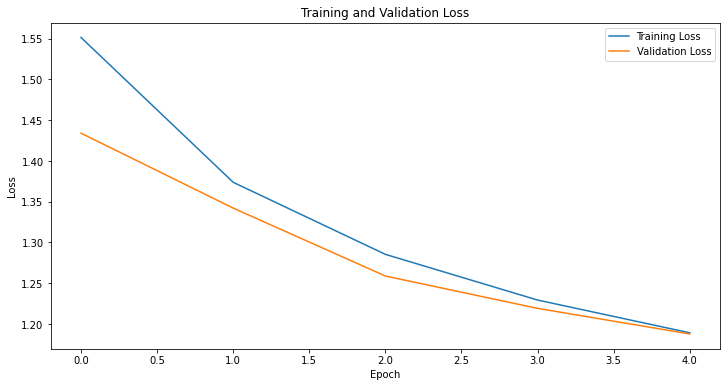

In [9]:
show_result(training_history)

- 학습 초기에 Validation Loss가 Training Loss 보다 낮게 나온다.
- 5 epoch 이후 부터 Loss가 높아질 것으로 보인다.
- 두 Loss 모두 아직 한창 감소하는 점으로 미루어 볼때 학습 최적점까지 에포크를 더 늘릴 필요가 있어 보인다.
- 다만, 학습 소요시간이 길다는 점을 감안하여 5 epoch 상태에서 먼저 비교한 다음 이후 계획을 세우고자 한다.

# simplebaseline 모델로 변경해 봅시다

Simplebaseline 모델은 StackedHourglass Network보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여준다고 한다.

실제로도 그런 성능을 얻을 수 있을지 확인해보고자 한다.

# STEP 1 : simplebaseline 모델 완성하기

- [Simple Baselines for Human Pose Estimation and Tracking](https://arxiv.org/pdf/1804.06208) 논문 2장  Pose Estimation Using A Deconvolution Head Network에서 등장하는 모델의 구조 관련 설명(아래 첨부)을 참고하여 모델링을 진행
>By default, three deconvolutional layers with batch normalization [15] and ReLU activation [19] are used. Each layer has 256 filters with 4 × 4 kernel. The stride is 2. A 1 × 1 convolutional layer is added at last to generate predicted heatmaps {H1 . . . Hk} for all k key points

In [17]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()

    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4),
                                                      strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())

    return seq_model

def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    upconv = _make_deconv_layer(3)
    final_layer = tf.keras.layers.Conv2D(num_heatmap,
                                         kernel_size=(1,1), padding='same')

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

# STEP 2 : simplebaseline 모델로 변경하여 훈련하기

StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

In [8]:
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_SBL_file, SBL_history = train(epochs,learning_rate, num_heatmap, batch_size,
                                   train_tfrecords, val_tfrecords,
                                   Simplebaseline)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.662081242 epoch total loss 0.662081242
Trained batch 2 batch loss 0.609602034 epoch total loss 0.635841608
Trained batch 3 batch loss 0.557064295 epoch total loss 0.609582484
Trained batch 4 batch loss 0.488326281 epoch total loss 0.579268456
Trained batch 5 batch loss 0.455356181 epoch total loss 0.554486
Trained batch 6 batch loss 0.495826691 epoch total loss 0.544709444
Trained batch 7 batch loss 0.455244482 epoch total loss 0.531928718
Trained batch 8 batch loss 0.44586274 epoch total loss 0.521170497
Trained batch 9 batch loss 0.444542468 epoch total loss 0.512656271
Trained batch 10 batch loss 0.427826881 epoch total loss 0.504173338
Trained batch 11 batch loss 0.448356777 epoch total loss 0.499099076
Trained batch 12 batch loss 0.411231041 epoch total loss 0.491776735
Trained batch 13 batch loss 0.411925614 epoch total loss 0.485634357
Trained batch 14 batch loss 0.420711577 epoch total loss 0.480997026
Trained batch 15

Trained batch 120 batch loss 0.328926086 epoch total loss 0.400389493
Trained batch 121 batch loss 0.341370344 epoch total loss 0.399901718
Trained batch 122 batch loss 0.317059 epoch total loss 0.399222672
Trained batch 123 batch loss 0.304109454 epoch total loss 0.398449391
Trained batch 124 batch loss 0.292832673 epoch total loss 0.397597611
Trained batch 125 batch loss 0.346378952 epoch total loss 0.397187859
Trained batch 126 batch loss 0.410314 epoch total loss 0.397292018
Trained batch 127 batch loss 0.393495381 epoch total loss 0.397262126
Trained batch 128 batch loss 0.362901717 epoch total loss 0.396993697
Trained batch 129 batch loss 0.369581938 epoch total loss 0.396781206
Trained batch 130 batch loss 0.378323823 epoch total loss 0.396639228
Trained batch 131 batch loss 0.346678525 epoch total loss 0.396257848
Trained batch 132 batch loss 0.359262496 epoch total loss 0.395977587
Trained batch 133 batch loss 0.374354064 epoch total loss 0.395815
Trained batch 134 batch loss 

Trained batch 238 batch loss 0.328858137 epoch total loss 0.383684814
Trained batch 239 batch loss 0.354829252 epoch total loss 0.383564085
Trained batch 240 batch loss 0.372668833 epoch total loss 0.383518666
Trained batch 241 batch loss 0.325717479 epoch total loss 0.383278817
Trained batch 242 batch loss 0.290614605 epoch total loss 0.382895887
Trained batch 243 batch loss 0.330047876 epoch total loss 0.382678419
Trained batch 244 batch loss 0.356433272 epoch total loss 0.382570833
Trained batch 245 batch loss 0.37365672 epoch total loss 0.382534444
Trained batch 246 batch loss 0.360805243 epoch total loss 0.38244611
Trained batch 247 batch loss 0.337169766 epoch total loss 0.382262826
Trained batch 248 batch loss 0.352471769 epoch total loss 0.382142693
Trained batch 249 batch loss 0.362579 epoch total loss 0.382064104
Trained batch 250 batch loss 0.364484787 epoch total loss 0.3819938
Trained batch 251 batch loss 0.342422724 epoch total loss 0.381836146
Trained batch 252 batch los

Trained batch 357 batch loss 0.327929497 epoch total loss 0.372859806
Trained batch 358 batch loss 0.318339676 epoch total loss 0.372707516
Trained batch 359 batch loss 0.332702 epoch total loss 0.372596085
Trained batch 360 batch loss 0.339278072 epoch total loss 0.372503549
Trained batch 361 batch loss 0.316976488 epoch total loss 0.372349709
Trained batch 362 batch loss 0.332384 epoch total loss 0.372239292
Trained batch 363 batch loss 0.333528697 epoch total loss 0.372132659
Trained batch 364 batch loss 0.372674912 epoch total loss 0.372134149
Trained batch 365 batch loss 0.370942265 epoch total loss 0.372130901
Trained batch 366 batch loss 0.388320178 epoch total loss 0.372175127
Trained batch 367 batch loss 0.349522889 epoch total loss 0.372113377
Trained batch 368 batch loss 0.342594087 epoch total loss 0.372033149
Trained batch 369 batch loss 0.334446371 epoch total loss 0.371931285
Trained batch 370 batch loss 0.357375473 epoch total loss 0.371891946
Trained batch 371 batch lo

Trained batch 475 batch loss 0.338639677 epoch total loss 0.36573261
Trained batch 476 batch loss 0.368210077 epoch total loss 0.365737826
Trained batch 477 batch loss 0.336409062 epoch total loss 0.365676343
Trained batch 478 batch loss 0.320299476 epoch total loss 0.365581393
Trained batch 479 batch loss 0.337197721 epoch total loss 0.365522146
Trained batch 480 batch loss 0.337389469 epoch total loss 0.365463555
Trained batch 481 batch loss 0.3510665 epoch total loss 0.365433604
Trained batch 482 batch loss 0.351136506 epoch total loss 0.36540392
Trained batch 483 batch loss 0.353703409 epoch total loss 0.365379691
Trained batch 484 batch loss 0.343630433 epoch total loss 0.365334749
Trained batch 485 batch loss 0.30631721 epoch total loss 0.365213066
Trained batch 486 batch loss 0.346332163 epoch total loss 0.365174204
Trained batch 487 batch loss 0.36142838 epoch total loss 0.365166545
Trained batch 488 batch loss 0.330430269 epoch total loss 0.365095347
Trained batch 489 batch lo

Trained batch 593 batch loss 0.332528234 epoch total loss 0.359511584
Trained batch 594 batch loss 0.336309463 epoch total loss 0.359472513
Trained batch 595 batch loss 0.348014653 epoch total loss 0.359453231
Trained batch 596 batch loss 0.325287759 epoch total loss 0.359395921
Trained batch 597 batch loss 0.349352211 epoch total loss 0.359379083
Trained batch 598 batch loss 0.360374779 epoch total loss 0.359380752
Trained batch 599 batch loss 0.350159675 epoch total loss 0.359365374
Trained batch 600 batch loss 0.327247798 epoch total loss 0.359311849
Trained batch 601 batch loss 0.342515796 epoch total loss 0.359283894
Trained batch 602 batch loss 0.32831189 epoch total loss 0.359232455
Trained batch 603 batch loss 0.301787376 epoch total loss 0.359137177
Trained batch 604 batch loss 0.318477333 epoch total loss 0.359069884
Trained batch 605 batch loss 0.319461018 epoch total loss 0.359004408
Trained batch 606 batch loss 0.315160751 epoch total loss 0.358932048
Trained batch 607 bat

Trained batch 711 batch loss 0.317696452 epoch total loss 0.354473412
Trained batch 712 batch loss 0.328052044 epoch total loss 0.354436308
Trained batch 713 batch loss 0.277415097 epoch total loss 0.354328275
Trained batch 714 batch loss 0.34128511 epoch total loss 0.35431
Trained batch 715 batch loss 0.34691456 epoch total loss 0.354299635
Trained batch 716 batch loss 0.337103695 epoch total loss 0.354275614
Trained batch 717 batch loss 0.34956035 epoch total loss 0.354269058
Trained batch 718 batch loss 0.342888743 epoch total loss 0.354253203
Trained batch 719 batch loss 0.341907203 epoch total loss 0.354236037
Trained batch 720 batch loss 0.338290334 epoch total loss 0.354213893
Trained batch 721 batch loss 0.311785936 epoch total loss 0.354155034
Trained batch 722 batch loss 0.2889373 epoch total loss 0.354064703
Trained batch 723 batch loss 0.316995621 epoch total loss 0.354013443
Trained batch 724 batch loss 0.340766728 epoch total loss 0.353995144
Trained batch 725 batch loss 

Trained batch 829 batch loss 0.310293704 epoch total loss 0.350996435
Trained batch 830 batch loss 0.305078328 epoch total loss 0.350941122
Trained batch 831 batch loss 0.326610446 epoch total loss 0.350911826
Trained batch 832 batch loss 0.311519921 epoch total loss 0.35086447
Trained batch 833 batch loss 0.369401604 epoch total loss 0.350886762
Trained batch 834 batch loss 0.33620429 epoch total loss 0.350869149
Trained batch 835 batch loss 0.347721398 epoch total loss 0.350865394
Trained batch 836 batch loss 0.326621532 epoch total loss 0.350836396
Trained batch 837 batch loss 0.316535592 epoch total loss 0.350795418
Trained batch 838 batch loss 0.343344837 epoch total loss 0.350786537
Trained batch 839 batch loss 0.348375499 epoch total loss 0.350783676
Trained batch 840 batch loss 0.352809072 epoch total loss 0.35078609
Trained batch 841 batch loss 0.359173059 epoch total loss 0.350796044
Trained batch 842 batch loss 0.334651291 epoch total loss 0.350776881
Trained batch 843 batch

Trained batch 947 batch loss 0.332035363 epoch total loss 0.348143965
Trained batch 948 batch loss 0.334042728 epoch total loss 0.348129094
Trained batch 949 batch loss 0.34250614 epoch total loss 0.348123133
Trained batch 950 batch loss 0.334884822 epoch total loss 0.348109215
Trained batch 951 batch loss 0.314646542 epoch total loss 0.348074019
Trained batch 952 batch loss 0.312647879 epoch total loss 0.348036826
Trained batch 953 batch loss 0.297743261 epoch total loss 0.347984046
Trained batch 954 batch loss 0.284694105 epoch total loss 0.347917706
Trained batch 955 batch loss 0.313053817 epoch total loss 0.347881198
Trained batch 956 batch loss 0.347527593 epoch total loss 0.34788081
Trained batch 957 batch loss 0.339933723 epoch total loss 0.347872525
Trained batch 958 batch loss 0.312281609 epoch total loss 0.347835362
Trained batch 959 batch loss 0.390645981 epoch total loss 0.347880036
Trained batch 960 batch loss 0.377694905 epoch total loss 0.34791106
Trained batch 961 batch

Trained batch 1064 batch loss 0.297247 epoch total loss 0.344895542
Trained batch 1065 batch loss 0.301643431 epoch total loss 0.344854951
Trained batch 1066 batch loss 0.315613747 epoch total loss 0.344827503
Trained batch 1067 batch loss 0.305430382 epoch total loss 0.344790578
Trained batch 1068 batch loss 0.312314421 epoch total loss 0.34476018
Trained batch 1069 batch loss 0.332539 epoch total loss 0.344748735
Trained batch 1070 batch loss 0.336789101 epoch total loss 0.344741315
Trained batch 1071 batch loss 0.350368 epoch total loss 0.34474656
Trained batch 1072 batch loss 0.32297343 epoch total loss 0.344726235
Trained batch 1073 batch loss 0.310822248 epoch total loss 0.344694644
Trained batch 1074 batch loss 0.316889942 epoch total loss 0.344668776
Trained batch 1075 batch loss 0.290602833 epoch total loss 0.344618469
Trained batch 1076 batch loss 0.283257127 epoch total loss 0.344561428
Trained batch 1077 batch loss 0.338591784 epoch total loss 0.344555885
Trained batch 1078

Trained batch 1181 batch loss 0.301956207 epoch total loss 0.34249267
Trained batch 1182 batch loss 0.32723242 epoch total loss 0.342479765
Trained batch 1183 batch loss 0.340199798 epoch total loss 0.342477858
Trained batch 1184 batch loss 0.34724158 epoch total loss 0.342481881
Trained batch 1185 batch loss 0.362016171 epoch total loss 0.342498362
Trained batch 1186 batch loss 0.393322945 epoch total loss 0.342541218
Trained batch 1187 batch loss 0.322777689 epoch total loss 0.342524558
Trained batch 1188 batch loss 0.32596004 epoch total loss 0.342510611
Trained batch 1189 batch loss 0.289631516 epoch total loss 0.342466146
Trained batch 1190 batch loss 0.340626448 epoch total loss 0.342464626
Trained batch 1191 batch loss 0.351315886 epoch total loss 0.342472047
Trained batch 1192 batch loss 0.370282263 epoch total loss 0.342495382
Trained batch 1193 batch loss 0.336909413 epoch total loss 0.342490703
Trained batch 1194 batch loss 0.331473023 epoch total loss 0.342481464
Trained ba

Trained batch 1298 batch loss 0.297800183 epoch total loss 0.340711
Trained batch 1299 batch loss 0.296304822 epoch total loss 0.340676785
Trained batch 1300 batch loss 0.292828768 epoch total loss 0.340639979
Trained batch 1301 batch loss 0.308429301 epoch total loss 0.340615213
Trained batch 1302 batch loss 0.303031266 epoch total loss 0.340586364
Trained batch 1303 batch loss 0.303132236 epoch total loss 0.340557635
Trained batch 1304 batch loss 0.307935387 epoch total loss 0.340532601
Trained batch 1305 batch loss 0.312334508 epoch total loss 0.340511
Trained batch 1306 batch loss 0.295451939 epoch total loss 0.340476483
Trained batch 1307 batch loss 0.315712065 epoch total loss 0.340457529
Trained batch 1308 batch loss 0.321382433 epoch total loss 0.340442955
Trained batch 1309 batch loss 0.317724824 epoch total loss 0.340425581
Trained batch 1310 batch loss 0.285476685 epoch total loss 0.340383649
Trained batch 1311 batch loss 0.253974259 epoch total loss 0.340317726
Trained batc

Validated batch 43 batch loss 0.278586179
Validated batch 44 batch loss 0.3204965
Validated batch 45 batch loss 0.350323707
Validated batch 46 batch loss 0.309995949
Validated batch 47 batch loss 0.340167969
Validated batch 48 batch loss 0.327021152
Validated batch 49 batch loss 0.321778685
Validated batch 50 batch loss 0.320162266
Validated batch 51 batch loss 0.322161347
Validated batch 52 batch loss 0.36212948
Validated batch 53 batch loss 0.300462842
Validated batch 54 batch loss 0.33803153
Validated batch 55 batch loss 0.323700547
Validated batch 56 batch loss 0.330450743
Validated batch 57 batch loss 0.320908427
Validated batch 58 batch loss 0.292043775
Validated batch 59 batch loss 0.358341098
Validated batch 60 batch loss 0.312914312
Validated batch 61 batch loss 0.335113406
Validated batch 62 batch loss 0.307495177
Validated batch 63 batch loss 0.337803543
Validated batch 64 batch loss 0.28409934
Validated batch 65 batch loss 0.319990128
Validated batch 66 batch loss 0.3052031

Trained batch 28 batch loss 0.301375657 epoch total loss 0.315860659
Trained batch 29 batch loss 0.292426974 epoch total loss 0.315052599
Trained batch 30 batch loss 0.292612106 epoch total loss 0.31430456
Trained batch 31 batch loss 0.255653977 epoch total loss 0.31241262
Trained batch 32 batch loss 0.250586569 epoch total loss 0.310480565
Trained batch 33 batch loss 0.289551586 epoch total loss 0.309846371
Trained batch 34 batch loss 0.304827958 epoch total loss 0.309698761
Trained batch 35 batch loss 0.316767663 epoch total loss 0.309900731
Trained batch 36 batch loss 0.28783381 epoch total loss 0.309287757
Trained batch 37 batch loss 0.287919402 epoch total loss 0.308710217
Trained batch 38 batch loss 0.280626357 epoch total loss 0.307971179
Trained batch 39 batch loss 0.277813584 epoch total loss 0.307197899
Trained batch 40 batch loss 0.272797614 epoch total loss 0.306337893
Trained batch 41 batch loss 0.291708231 epoch total loss 0.30598107
Trained batch 42 batch loss 0.31348797

Trained batch 147 batch loss 0.320438445 epoch total loss 0.310570359
Trained batch 148 batch loss 0.306904912 epoch total loss 0.310545594
Trained batch 149 batch loss 0.318161488 epoch total loss 0.310596704
Trained batch 150 batch loss 0.316732645 epoch total loss 0.310637623
Trained batch 151 batch loss 0.266123563 epoch total loss 0.310342818
Trained batch 152 batch loss 0.289045781 epoch total loss 0.310202718
Trained batch 153 batch loss 0.280896366 epoch total loss 0.310011178
Trained batch 154 batch loss 0.290691 epoch total loss 0.30988571
Trained batch 155 batch loss 0.277284503 epoch total loss 0.309675366
Trained batch 156 batch loss 0.332339764 epoch total loss 0.309820652
Trained batch 157 batch loss 0.314608693 epoch total loss 0.30985117
Trained batch 158 batch loss 0.307535917 epoch total loss 0.309836507
Trained batch 159 batch loss 0.314661264 epoch total loss 0.309866875
Trained batch 160 batch loss 0.316785932 epoch total loss 0.309910119
Trained batch 161 batch l

Trained batch 265 batch loss 0.345457226 epoch total loss 0.313022077
Trained batch 266 batch loss 0.327165902 epoch total loss 0.313075244
Trained batch 267 batch loss 0.314691782 epoch total loss 0.313081294
Trained batch 268 batch loss 0.306708694 epoch total loss 0.313057512
Trained batch 269 batch loss 0.268474281 epoch total loss 0.312891752
Trained batch 270 batch loss 0.280429929 epoch total loss 0.312771559
Trained batch 271 batch loss 0.268362224 epoch total loss 0.312607676
Trained batch 272 batch loss 0.296123 epoch total loss 0.312547058
Trained batch 273 batch loss 0.272303104 epoch total loss 0.312399656
Trained batch 274 batch loss 0.242297813 epoch total loss 0.312143773
Trained batch 275 batch loss 0.249023363 epoch total loss 0.311914265
Trained batch 276 batch loss 0.221997887 epoch total loss 0.311588466
Trained batch 277 batch loss 0.280223191 epoch total loss 0.311475247
Trained batch 278 batch loss 0.31973061 epoch total loss 0.31150493
Trained batch 279 batch l

Trained batch 383 batch loss 0.332987398 epoch total loss 0.312228918
Trained batch 384 batch loss 0.313587487 epoch total loss 0.312232465
Trained batch 385 batch loss 0.318445116 epoch total loss 0.312248588
Trained batch 386 batch loss 0.35128656 epoch total loss 0.312349737
Trained batch 387 batch loss 0.360827625 epoch total loss 0.312475
Trained batch 388 batch loss 0.314210862 epoch total loss 0.312479466
Trained batch 389 batch loss 0.284940362 epoch total loss 0.312408656
Trained batch 390 batch loss 0.302889943 epoch total loss 0.312384248
Trained batch 391 batch loss 0.292675018 epoch total loss 0.312333822
Trained batch 392 batch loss 0.305265069 epoch total loss 0.312315792
Trained batch 393 batch loss 0.318205476 epoch total loss 0.312330782
Trained batch 394 batch loss 0.321827739 epoch total loss 0.312354892
Trained batch 395 batch loss 0.30206722 epoch total loss 0.312328875
Trained batch 396 batch loss 0.3183828 epoch total loss 0.312344164
Trained batch 397 batch los

Trained batch 501 batch loss 0.32455349 epoch total loss 0.310491771
Trained batch 502 batch loss 0.325227261 epoch total loss 0.310521126
Trained batch 503 batch loss 0.308025509 epoch total loss 0.310516179
Trained batch 504 batch loss 0.322488666 epoch total loss 0.310539931
Trained batch 505 batch loss 0.330942869 epoch total loss 0.310580343
Trained batch 506 batch loss 0.315205753 epoch total loss 0.310589492
Trained batch 507 batch loss 0.334439367 epoch total loss 0.31063652
Trained batch 508 batch loss 0.325117022 epoch total loss 0.310665041
Trained batch 509 batch loss 0.312228203 epoch total loss 0.310668111
Trained batch 510 batch loss 0.318719327 epoch total loss 0.310683906
Trained batch 511 batch loss 0.337311864 epoch total loss 0.310736
Trained batch 512 batch loss 0.318581 epoch total loss 0.310751349
Trained batch 513 batch loss 0.321702272 epoch total loss 0.310772687
Trained batch 514 batch loss 0.295987278 epoch total loss 0.310743928
Trained batch 515 batch loss

Trained batch 619 batch loss 0.30416289 epoch total loss 0.310129166
Trained batch 620 batch loss 0.311470866 epoch total loss 0.310131341
Trained batch 621 batch loss 0.329862 epoch total loss 0.31016311
Trained batch 622 batch loss 0.307481587 epoch total loss 0.310158819
Trained batch 623 batch loss 0.305102587 epoch total loss 0.310150683
Trained batch 624 batch loss 0.285070837 epoch total loss 0.31011048
Trained batch 625 batch loss 0.29159838 epoch total loss 0.310080856
Trained batch 626 batch loss 0.307927132 epoch total loss 0.310077399
Trained batch 627 batch loss 0.301945388 epoch total loss 0.310064435
Trained batch 628 batch loss 0.2663562 epoch total loss 0.309994847
Trained batch 629 batch loss 0.251355559 epoch total loss 0.309901625
Trained batch 630 batch loss 0.298344374 epoch total loss 0.309883267
Trained batch 631 batch loss 0.334167153 epoch total loss 0.309921741
Trained batch 632 batch loss 0.304177731 epoch total loss 0.309912682
Trained batch 633 batch loss 

Trained batch 737 batch loss 0.281208038 epoch total loss 0.310662568
Trained batch 738 batch loss 0.306015521 epoch total loss 0.310656279
Trained batch 739 batch loss 0.278023899 epoch total loss 0.310612112
Trained batch 740 batch loss 0.310274959 epoch total loss 0.310611665
Trained batch 741 batch loss 0.308375955 epoch total loss 0.310608655
Trained batch 742 batch loss 0.325245678 epoch total loss 0.310628384
Trained batch 743 batch loss 0.250992 epoch total loss 0.310548097
Trained batch 744 batch loss 0.33409059 epoch total loss 0.310579747
Trained batch 745 batch loss 0.336975515 epoch total loss 0.310615182
Trained batch 746 batch loss 0.324415356 epoch total loss 0.310633689
Trained batch 747 batch loss 0.277357936 epoch total loss 0.310589135
Trained batch 748 batch loss 0.260305107 epoch total loss 0.310521901
Trained batch 749 batch loss 0.272029549 epoch total loss 0.310470521
Trained batch 750 batch loss 0.283755839 epoch total loss 0.310434908
Trained batch 751 batch 

Trained batch 855 batch loss 0.294035882 epoch total loss 0.309016317
Trained batch 856 batch loss 0.283594579 epoch total loss 0.308986634
Trained batch 857 batch loss 0.298987359 epoch total loss 0.308974952
Trained batch 858 batch loss 0.305637211 epoch total loss 0.308971047
Trained batch 859 batch loss 0.297928184 epoch total loss 0.308958232
Trained batch 860 batch loss 0.281558126 epoch total loss 0.308926344
Trained batch 861 batch loss 0.289894938 epoch total loss 0.308904231
Trained batch 862 batch loss 0.296835303 epoch total loss 0.308890253
Trained batch 863 batch loss 0.298266321 epoch total loss 0.308877945
Trained batch 864 batch loss 0.300136 epoch total loss 0.308867842
Trained batch 865 batch loss 0.300335288 epoch total loss 0.308857977
Trained batch 866 batch loss 0.322260916 epoch total loss 0.308873445
Trained batch 867 batch loss 0.316420734 epoch total loss 0.308882147
Trained batch 868 batch loss 0.334143281 epoch total loss 0.308911234
Trained batch 869 batch

Trained batch 973 batch loss 0.29029128 epoch total loss 0.308961868
Trained batch 974 batch loss 0.340258688 epoch total loss 0.308994025
Trained batch 975 batch loss 0.327257127 epoch total loss 0.309012771
Trained batch 976 batch loss 0.292960942 epoch total loss 0.30899632
Trained batch 977 batch loss 0.33988893 epoch total loss 0.30902794
Trained batch 978 batch loss 0.284712017 epoch total loss 0.309003055
Trained batch 979 batch loss 0.258964628 epoch total loss 0.308951944
Trained batch 980 batch loss 0.273068398 epoch total loss 0.308915347
Trained batch 981 batch loss 0.265954673 epoch total loss 0.308871537
Trained batch 982 batch loss 0.330519885 epoch total loss 0.308893591
Trained batch 983 batch loss 0.304148793 epoch total loss 0.308888733
Trained batch 984 batch loss 0.342660785 epoch total loss 0.308923066
Trained batch 985 batch loss 0.322688401 epoch total loss 0.308937043
Trained batch 986 batch loss 0.292514801 epoch total loss 0.308920383
Trained batch 987 batch 

Trained batch 1090 batch loss 0.303018451 epoch total loss 0.308520049
Trained batch 1091 batch loss 0.308054209 epoch total loss 0.308519632
Trained batch 1092 batch loss 0.315235794 epoch total loss 0.308525771
Trained batch 1093 batch loss 0.320900202 epoch total loss 0.308537096
Trained batch 1094 batch loss 0.327492267 epoch total loss 0.308554411
Trained batch 1095 batch loss 0.290508866 epoch total loss 0.30853793
Trained batch 1096 batch loss 0.312092483 epoch total loss 0.308541179
Trained batch 1097 batch loss 0.30728966 epoch total loss 0.308540016
Trained batch 1098 batch loss 0.294322938 epoch total loss 0.308527082
Trained batch 1099 batch loss 0.298180968 epoch total loss 0.308517665
Trained batch 1100 batch loss 0.240954816 epoch total loss 0.308456242
Trained batch 1101 batch loss 0.231067628 epoch total loss 0.308385968
Trained batch 1102 batch loss 0.279464364 epoch total loss 0.308359712
Trained batch 1103 batch loss 0.324098259 epoch total loss 0.308374
Trained bat

Trained batch 1206 batch loss 0.347909838 epoch total loss 0.308861345
Trained batch 1207 batch loss 0.30657652 epoch total loss 0.308859468
Trained batch 1208 batch loss 0.332081378 epoch total loss 0.30887869
Trained batch 1209 batch loss 0.292574346 epoch total loss 0.30886519
Trained batch 1210 batch loss 0.316414326 epoch total loss 0.308871448
Trained batch 1211 batch loss 0.28853938 epoch total loss 0.30885464
Trained batch 1212 batch loss 0.291814029 epoch total loss 0.308840573
Trained batch 1213 batch loss 0.288083464 epoch total loss 0.308823466
Trained batch 1214 batch loss 0.276042491 epoch total loss 0.308796465
Trained batch 1215 batch loss 0.298537672 epoch total loss 0.308788
Trained batch 1216 batch loss 0.281307101 epoch total loss 0.308765411
Trained batch 1217 batch loss 0.306332439 epoch total loss 0.308763415
Trained batch 1218 batch loss 0.30488351 epoch total loss 0.308760226
Trained batch 1219 batch loss 0.303728551 epoch total loss 0.308756113
Trained batch 1

Trained batch 1323 batch loss 0.314976752 epoch total loss 0.307997108
Trained batch 1324 batch loss 0.284589112 epoch total loss 0.307979405
Trained batch 1325 batch loss 0.294912964 epoch total loss 0.30796957
Trained batch 1326 batch loss 0.324933946 epoch total loss 0.307982326
Trained batch 1327 batch loss 0.284813941 epoch total loss 0.307964891
Trained batch 1328 batch loss 0.304457784 epoch total loss 0.307962239
Trained batch 1329 batch loss 0.293159634 epoch total loss 0.307951093
Trained batch 1330 batch loss 0.284657598 epoch total loss 0.307933569
Trained batch 1331 batch loss 0.316858113 epoch total loss 0.307940304
Trained batch 1332 batch loss 0.300856531 epoch total loss 0.30793497
Trained batch 1333 batch loss 0.296211511 epoch total loss 0.307926178
Trained batch 1334 batch loss 0.318323523 epoch total loss 0.307933956
Trained batch 1335 batch loss 0.297173977 epoch total loss 0.30792591
Trained batch 1336 batch loss 0.310057521 epoch total loss 0.307927489
Trained b

Validated batch 85 batch loss 0.333122224
Validated batch 86 batch loss 0.27487877
Validated batch 87 batch loss 0.320405841
Validated batch 88 batch loss 0.263110578
Validated batch 89 batch loss 0.280411422
Validated batch 90 batch loss 0.284011066
Validated batch 91 batch loss 0.294538498
Validated batch 92 batch loss 0.343341708
Validated batch 93 batch loss 0.305819243
Validated batch 94 batch loss 0.270030499
Validated batch 95 batch loss 0.305964708
Validated batch 96 batch loss 0.286732882
Validated batch 97 batch loss 0.293813735
Validated batch 98 batch loss 0.307958782
Validated batch 99 batch loss 0.30387491
Validated batch 100 batch loss 0.306918412
Validated batch 101 batch loss 0.302794218
Validated batch 102 batch loss 0.276576877
Validated batch 103 batch loss 0.323150635
Validated batch 104 batch loss 0.307900935
Validated batch 105 batch loss 0.290329635
Validated batch 106 batch loss 0.290163159
Validated batch 107 batch loss 0.317539334
Validated batch 108 batch lo

Trained batch 54 batch loss 0.276417196 epoch total loss 0.294083834
Trained batch 55 batch loss 0.269466221 epoch total loss 0.293636233
Trained batch 56 batch loss 0.272144347 epoch total loss 0.293252438
Trained batch 57 batch loss 0.310932547 epoch total loss 0.293562591
Trained batch 58 batch loss 0.316811442 epoch total loss 0.293963432
Trained batch 59 batch loss 0.27292347 epoch total loss 0.293606848
Trained batch 60 batch loss 0.282926947 epoch total loss 0.293428838
Trained batch 61 batch loss 0.310255319 epoch total loss 0.293704689
Trained batch 62 batch loss 0.27491039 epoch total loss 0.293401539
Trained batch 63 batch loss 0.286359 epoch total loss 0.293289751
Trained batch 64 batch loss 0.308796048 epoch total loss 0.293532044
Trained batch 65 batch loss 0.33590138 epoch total loss 0.29418388
Trained batch 66 batch loss 0.334326953 epoch total loss 0.294792116
Trained batch 67 batch loss 0.385853916 epoch total loss 0.296151251
Trained batch 68 batch loss 0.301798344 e

Trained batch 173 batch loss 0.322462261 epoch total loss 0.300099373
Trained batch 174 batch loss 0.299359262 epoch total loss 0.300095111
Trained batch 175 batch loss 0.263994902 epoch total loss 0.299888819
Trained batch 176 batch loss 0.288593709 epoch total loss 0.299824655
Trained batch 177 batch loss 0.29118222 epoch total loss 0.299775839
Trained batch 178 batch loss 0.309947 epoch total loss 0.29983297
Trained batch 179 batch loss 0.299919426 epoch total loss 0.299833447
Trained batch 180 batch loss 0.307665586 epoch total loss 0.299877
Trained batch 181 batch loss 0.299111307 epoch total loss 0.299872726
Trained batch 182 batch loss 0.29616794 epoch total loss 0.299852401
Trained batch 183 batch loss 0.303641289 epoch total loss 0.299873114
Trained batch 184 batch loss 0.349809587 epoch total loss 0.300144494
Trained batch 185 batch loss 0.314944953 epoch total loss 0.300224483
Trained batch 186 batch loss 0.274678409 epoch total loss 0.300087154
Trained batch 187 batch loss 

Trained batch 291 batch loss 0.26018545 epoch total loss 0.298170537
Trained batch 292 batch loss 0.299212366 epoch total loss 0.298174083
Trained batch 293 batch loss 0.27190581 epoch total loss 0.298084438
Trained batch 294 batch loss 0.277109325 epoch total loss 0.298013091
Trained batch 295 batch loss 0.29044494 epoch total loss 0.297987431
Trained batch 296 batch loss 0.346540064 epoch total loss 0.298151463
Trained batch 297 batch loss 0.305722117 epoch total loss 0.298176944
Trained batch 298 batch loss 0.278786063 epoch total loss 0.298111886
Trained batch 299 batch loss 0.347140968 epoch total loss 0.298275858
Trained batch 300 batch loss 0.359535307 epoch total loss 0.298480034
Trained batch 301 batch loss 0.316451788 epoch total loss 0.298539758
Trained batch 302 batch loss 0.320115268 epoch total loss 0.298611194
Trained batch 303 batch loss 0.280065536 epoch total loss 0.29854998
Trained batch 304 batch loss 0.289024562 epoch total loss 0.298518658
Trained batch 305 batch 

Trained batch 409 batch loss 0.265599549 epoch total loss 0.298413
Trained batch 410 batch loss 0.268428475 epoch total loss 0.298339874
Trained batch 411 batch loss 0.283550501 epoch total loss 0.298303902
Trained batch 412 batch loss 0.301924586 epoch total loss 0.298312694
Trained batch 413 batch loss 0.325453788 epoch total loss 0.298378408
Trained batch 414 batch loss 0.290832967 epoch total loss 0.298360199
Trained batch 415 batch loss 0.320566803 epoch total loss 0.298413694
Trained batch 416 batch loss 0.322177351 epoch total loss 0.298470795
Trained batch 417 batch loss 0.318873525 epoch total loss 0.298519731
Trained batch 418 batch loss 0.311645389 epoch total loss 0.298551142
Trained batch 419 batch loss 0.312388629 epoch total loss 0.298584133
Trained batch 420 batch loss 0.300473303 epoch total loss 0.298588663
Trained batch 421 batch loss 0.280518293 epoch total loss 0.298545718
Trained batch 422 batch loss 0.27176702 epoch total loss 0.298482269
Trained batch 423 batch 

Trained batch 527 batch loss 0.26668933 epoch total loss 0.297510237
Trained batch 528 batch loss 0.300680131 epoch total loss 0.297516227
Trained batch 529 batch loss 0.315463126 epoch total loss 0.297550142
Trained batch 530 batch loss 0.317170858 epoch total loss 0.297587156
Trained batch 531 batch loss 0.312175572 epoch total loss 0.297614634
Trained batch 532 batch loss 0.268639266 epoch total loss 0.297560185
Trained batch 533 batch loss 0.303493 epoch total loss 0.297571331
Trained batch 534 batch loss 0.296168089 epoch total loss 0.297568709
Trained batch 535 batch loss 0.278738767 epoch total loss 0.297533482
Trained batch 536 batch loss 0.224990427 epoch total loss 0.29739815
Trained batch 537 batch loss 0.239886686 epoch total loss 0.29729104
Trained batch 538 batch loss 0.273225158 epoch total loss 0.297246307
Trained batch 539 batch loss 0.31619361 epoch total loss 0.297281474
Trained batch 540 batch loss 0.321367979 epoch total loss 0.297326058
Trained batch 541 batch los

Trained batch 645 batch loss 0.290219605 epoch total loss 0.297472417
Trained batch 646 batch loss 0.325824499 epoch total loss 0.297516286
Trained batch 647 batch loss 0.291474849 epoch total loss 0.297506958
Trained batch 648 batch loss 0.281035036 epoch total loss 0.297481537
Trained batch 649 batch loss 0.270953059 epoch total loss 0.297440648
Trained batch 650 batch loss 0.267680526 epoch total loss 0.297394872
Trained batch 651 batch loss 0.234006718 epoch total loss 0.297297508
Trained batch 652 batch loss 0.22102505 epoch total loss 0.297180533
Trained batch 653 batch loss 0.239831969 epoch total loss 0.297092706
Trained batch 654 batch loss 0.28287366 epoch total loss 0.29707095
Trained batch 655 batch loss 0.327264428 epoch total loss 0.297117054
Trained batch 656 batch loss 0.394529134 epoch total loss 0.297265559
Trained batch 657 batch loss 0.2976394 epoch total loss 0.297266126
Trained batch 658 batch loss 0.319323659 epoch total loss 0.297299653
Trained batch 659 batch l

Trained batch 763 batch loss 0.239619717 epoch total loss 0.296506643
Trained batch 764 batch loss 0.233434379 epoch total loss 0.296424061
Trained batch 765 batch loss 0.301920891 epoch total loss 0.296431273
Trained batch 766 batch loss 0.303446054 epoch total loss 0.296440423
Trained batch 767 batch loss 0.32103321 epoch total loss 0.29647249
Trained batch 768 batch loss 0.31313169 epoch total loss 0.296494156
Trained batch 769 batch loss 0.281195074 epoch total loss 0.296474278
Trained batch 770 batch loss 0.261275589 epoch total loss 0.296428561
Trained batch 771 batch loss 0.286481619 epoch total loss 0.296415657
Trained batch 772 batch loss 0.30667 epoch total loss 0.296428949
Trained batch 773 batch loss 0.298746347 epoch total loss 0.296431929
Trained batch 774 batch loss 0.297394425 epoch total loss 0.296433181
Trained batch 775 batch loss 0.330595732 epoch total loss 0.296477258
Trained batch 776 batch loss 0.33798337 epoch total loss 0.296530753
Trained batch 777 batch loss

Trained batch 881 batch loss 0.272101969 epoch total loss 0.295621663
Trained batch 882 batch loss 0.293421924 epoch total loss 0.29561919
Trained batch 883 batch loss 0.282096088 epoch total loss 0.295603871
Trained batch 884 batch loss 0.282309145 epoch total loss 0.295588851
Trained batch 885 batch loss 0.267183512 epoch total loss 0.295556754
Trained batch 886 batch loss 0.296399951 epoch total loss 0.295557678
Trained batch 887 batch loss 0.292775124 epoch total loss 0.295554549
Trained batch 888 batch loss 0.294852614 epoch total loss 0.295553774
Trained batch 889 batch loss 0.319023579 epoch total loss 0.295580178
Trained batch 890 batch loss 0.332204968 epoch total loss 0.295621336
Trained batch 891 batch loss 0.304057091 epoch total loss 0.295630813
Trained batch 892 batch loss 0.263189405 epoch total loss 0.295594424
Trained batch 893 batch loss 0.265534729 epoch total loss 0.295560747
Trained batch 894 batch loss 0.281096399 epoch total loss 0.295544595
Trained batch 895 bat

Trained batch 999 batch loss 0.340425372 epoch total loss 0.295089453
Trained batch 1000 batch loss 0.328439921 epoch total loss 0.295122802
Trained batch 1001 batch loss 0.307239801 epoch total loss 0.295134932
Trained batch 1002 batch loss 0.280652761 epoch total loss 0.295120448
Trained batch 1003 batch loss 0.288855076 epoch total loss 0.295114189
Trained batch 1004 batch loss 0.307681441 epoch total loss 0.295126706
Trained batch 1005 batch loss 0.297843456 epoch total loss 0.295129418
Trained batch 1006 batch loss 0.281805634 epoch total loss 0.295116186
Trained batch 1007 batch loss 0.319348603 epoch total loss 0.295140237
Trained batch 1008 batch loss 0.301159531 epoch total loss 0.295146197
Trained batch 1009 batch loss 0.278864563 epoch total loss 0.295130044
Trained batch 1010 batch loss 0.314864188 epoch total loss 0.295149565
Trained batch 1011 batch loss 0.287034124 epoch total loss 0.295141578
Trained batch 1012 batch loss 0.254746765 epoch total loss 0.295101672
Trained

Trained batch 1115 batch loss 0.350322306 epoch total loss 0.294629663
Trained batch 1116 batch loss 0.346681863 epoch total loss 0.294676304
Trained batch 1117 batch loss 0.306644738 epoch total loss 0.294687033
Trained batch 1118 batch loss 0.318703115 epoch total loss 0.29470849
Trained batch 1119 batch loss 0.312429041 epoch total loss 0.294724345
Trained batch 1120 batch loss 0.265162617 epoch total loss 0.29469794
Trained batch 1121 batch loss 0.264720291 epoch total loss 0.294671208
Trained batch 1122 batch loss 0.277175635 epoch total loss 0.294655591
Trained batch 1123 batch loss 0.295186132 epoch total loss 0.294656068
Trained batch 1124 batch loss 0.304130346 epoch total loss 0.294664502
Trained batch 1125 batch loss 0.313033 epoch total loss 0.294680834
Trained batch 1126 batch loss 0.292855233 epoch total loss 0.294679195
Trained batch 1127 batch loss 0.304414749 epoch total loss 0.294687837
Trained batch 1128 batch loss 0.291904509 epoch total loss 0.294685364
Trained bat

Trained batch 1231 batch loss 0.328884333 epoch total loss 0.294855773
Trained batch 1232 batch loss 0.301633567 epoch total loss 0.294861287
Trained batch 1233 batch loss 0.313405812 epoch total loss 0.294876337
Trained batch 1234 batch loss 0.253654242 epoch total loss 0.294842929
Trained batch 1235 batch loss 0.279655695 epoch total loss 0.29483065
Trained batch 1236 batch loss 0.27374506 epoch total loss 0.294813573
Trained batch 1237 batch loss 0.239106134 epoch total loss 0.294768542
Trained batch 1238 batch loss 0.272357792 epoch total loss 0.294750452
Trained batch 1239 batch loss 0.295881957 epoch total loss 0.294751346
Trained batch 1240 batch loss 0.319678158 epoch total loss 0.294771463
Trained batch 1241 batch loss 0.311703056 epoch total loss 0.294785112
Trained batch 1242 batch loss 0.314343572 epoch total loss 0.294800848
Trained batch 1243 batch loss 0.326714754 epoch total loss 0.294826508
Trained batch 1244 batch loss 0.313538432 epoch total loss 0.294841558
Trained 

Trained batch 1347 batch loss 0.338351309 epoch total loss 0.294902086
Trained batch 1348 batch loss 0.350340962 epoch total loss 0.294943213
Trained batch 1349 batch loss 0.31342864 epoch total loss 0.294956893
Trained batch 1350 batch loss 0.302570343 epoch total loss 0.294962555
Trained batch 1351 batch loss 0.277087599 epoch total loss 0.294949323
Trained batch 1352 batch loss 0.280899704 epoch total loss 0.294938952
Trained batch 1353 batch loss 0.286615521 epoch total loss 0.294932783
Trained batch 1354 batch loss 0.314711332 epoch total loss 0.294947386
Trained batch 1355 batch loss 0.298164189 epoch total loss 0.29494977
Trained batch 1356 batch loss 0.263380229 epoch total loss 0.294926465
Trained batch 1357 batch loss 0.261202633 epoch total loss 0.294901609
Trained batch 1358 batch loss 0.239211917 epoch total loss 0.294860601
Trained batch 1359 batch loss 0.254627973 epoch total loss 0.294831
Trained batch 1360 batch loss 0.287749469 epoch total loss 0.294825792
Trained bat

Validated batch 125 batch loss 0.310602
Validated batch 126 batch loss 0.316176951
Validated batch 127 batch loss 0.315091282
Validated batch 128 batch loss 0.307635963
Validated batch 129 batch loss 0.282995313
Validated batch 130 batch loss 0.287863314
Validated batch 131 batch loss 0.307239711
Validated batch 132 batch loss 0.297012568
Validated batch 133 batch loss 0.306905806
Validated batch 134 batch loss 0.306656629
Validated batch 135 batch loss 0.350881934
Validated batch 136 batch loss 0.335858077
Validated batch 137 batch loss 0.297929436
Validated batch 138 batch loss 0.273665726
Validated batch 139 batch loss 0.26510787
Validated batch 140 batch loss 0.293799728
Validated batch 141 batch loss 0.292315602
Validated batch 142 batch loss 0.270644337
Validated batch 143 batch loss 0.297728
Validated batch 144 batch loss 0.327206582
Validated batch 145 batch loss 0.269429147
Validated batch 146 batch loss 0.267146736
Validated batch 147 batch loss 0.283668488
Validated batch 14

Trained batch 79 batch loss 0.293139905 epoch total loss 0.283729911
Trained batch 80 batch loss 0.28929764 epoch total loss 0.283799499
Trained batch 81 batch loss 0.302606165 epoch total loss 0.284031689
Trained batch 82 batch loss 0.316692263 epoch total loss 0.28443
Trained batch 83 batch loss 0.326787829 epoch total loss 0.284940332
Trained batch 84 batch loss 0.320743561 epoch total loss 0.285366565
Trained batch 85 batch loss 0.329711229 epoch total loss 0.285888255
Trained batch 86 batch loss 0.264421 epoch total loss 0.28563866
Trained batch 87 batch loss 0.283248752 epoch total loss 0.285611182
Trained batch 88 batch loss 0.291395 epoch total loss 0.285676926
Trained batch 89 batch loss 0.2871719 epoch total loss 0.285693705
Trained batch 90 batch loss 0.273851514 epoch total loss 0.285562128
Trained batch 91 batch loss 0.246282771 epoch total loss 0.285130501
Trained batch 92 batch loss 0.268715739 epoch total loss 0.284952074
Trained batch 93 batch loss 0.264999151 epoch to

Trained batch 197 batch loss 0.278691113 epoch total loss 0.283927679
Trained batch 198 batch loss 0.266640246 epoch total loss 0.283840358
Trained batch 199 batch loss 0.250193834 epoch total loss 0.28367129
Trained batch 200 batch loss 0.240210831 epoch total loss 0.283453971
Trained batch 201 batch loss 0.277084827 epoch total loss 0.283422291
Trained batch 202 batch loss 0.268113852 epoch total loss 0.283346504
Trained batch 203 batch loss 0.246372983 epoch total loss 0.283164352
Trained batch 204 batch loss 0.265124589 epoch total loss 0.283075929
Trained batch 205 batch loss 0.238953263 epoch total loss 0.282860696
Trained batch 206 batch loss 0.283344418 epoch total loss 0.282863051
Trained batch 207 batch loss 0.251123548 epoch total loss 0.282709718
Trained batch 208 batch loss 0.278328091 epoch total loss 0.282688648
Trained batch 209 batch loss 0.282985687 epoch total loss 0.282690078
Trained batch 210 batch loss 0.279202431 epoch total loss 0.282673478
Trained batch 211 bat

Trained batch 315 batch loss 0.314898968 epoch total loss 0.283888906
Trained batch 316 batch loss 0.305761099 epoch total loss 0.283958107
Trained batch 317 batch loss 0.300400436 epoch total loss 0.28401
Trained batch 318 batch loss 0.279435 epoch total loss 0.283995599
Trained batch 319 batch loss 0.306260914 epoch total loss 0.284065396
Trained batch 320 batch loss 0.285413176 epoch total loss 0.284069598
Trained batch 321 batch loss 0.251172602 epoch total loss 0.283967137
Trained batch 322 batch loss 0.282737792 epoch total loss 0.283963323
Trained batch 323 batch loss 0.301862657 epoch total loss 0.284018725
Trained batch 324 batch loss 0.295094758 epoch total loss 0.284052938
Trained batch 325 batch loss 0.300026149 epoch total loss 0.284102082
Trained batch 326 batch loss 0.305169493 epoch total loss 0.284166694
Trained batch 327 batch loss 0.290434271 epoch total loss 0.284185857
Trained batch 328 batch loss 0.311008096 epoch total loss 0.284267634
Trained batch 329 batch los

Trained batch 433 batch loss 0.268593282 epoch total loss 0.284421325
Trained batch 434 batch loss 0.277307838 epoch total loss 0.284404933
Trained batch 435 batch loss 0.248033255 epoch total loss 0.284321308
Trained batch 436 batch loss 0.303520501 epoch total loss 0.284365356
Trained batch 437 batch loss 0.281587243 epoch total loss 0.284358978
Trained batch 438 batch loss 0.284139842 epoch total loss 0.284358501
Trained batch 439 batch loss 0.279014409 epoch total loss 0.284346312
Trained batch 440 batch loss 0.272197902 epoch total loss 0.284318715
Trained batch 441 batch loss 0.264695823 epoch total loss 0.28427422
Trained batch 442 batch loss 0.265357554 epoch total loss 0.284231424
Trained batch 443 batch loss 0.261784136 epoch total loss 0.28418076
Trained batch 444 batch loss 0.294554889 epoch total loss 0.284204125
Trained batch 445 batch loss 0.276257515 epoch total loss 0.284186274
Trained batch 446 batch loss 0.271079212 epoch total loss 0.284156889
Trained batch 447 batc

Trained batch 551 batch loss 0.242457092 epoch total loss 0.285347372
Trained batch 552 batch loss 0.225724548 epoch total loss 0.285239369
Trained batch 553 batch loss 0.268002301 epoch total loss 0.285208195
Trained batch 554 batch loss 0.268228471 epoch total loss 0.285177559
Trained batch 555 batch loss 0.221459389 epoch total loss 0.28506276
Trained batch 556 batch loss 0.225527182 epoch total loss 0.28495568
Trained batch 557 batch loss 0.225300774 epoch total loss 0.284848571
Trained batch 558 batch loss 0.253113538 epoch total loss 0.284791708
Trained batch 559 batch loss 0.241438895 epoch total loss 0.284714162
Trained batch 560 batch loss 0.280798644 epoch total loss 0.284707159
Trained batch 561 batch loss 0.309005886 epoch total loss 0.284750462
Trained batch 562 batch loss 0.263017833 epoch total loss 0.284711778
Trained batch 563 batch loss 0.282575756 epoch total loss 0.284708
Trained batch 564 batch loss 0.315450907 epoch total loss 0.284762502
Trained batch 565 batch l

Trained batch 669 batch loss 0.277409881 epoch total loss 0.285059899
Trained batch 670 batch loss 0.307000339 epoch total loss 0.285092652
Trained batch 671 batch loss 0.273743778 epoch total loss 0.285075754
Trained batch 672 batch loss 0.295289874 epoch total loss 0.285090953
Trained batch 673 batch loss 0.2719962 epoch total loss 0.285071492
Trained batch 674 batch loss 0.27963528 epoch total loss 0.285063416
Trained batch 675 batch loss 0.281229198 epoch total loss 0.285057753
Trained batch 676 batch loss 0.255995095 epoch total loss 0.285014778
Trained batch 677 batch loss 0.270579726 epoch total loss 0.28499344
Trained batch 678 batch loss 0.29484871 epoch total loss 0.285007983
Trained batch 679 batch loss 0.26987803 epoch total loss 0.284985721
Trained batch 680 batch loss 0.240387842 epoch total loss 0.284920126
Trained batch 681 batch loss 0.294537455 epoch total loss 0.284934253
Trained batch 682 batch loss 0.274536133 epoch total loss 0.284919
Trained batch 683 batch loss 

Trained batch 788 batch loss 0.303075314 epoch total loss 0.285750389
Trained batch 789 batch loss 0.26334092 epoch total loss 0.285721958
Trained batch 790 batch loss 0.286439896 epoch total loss 0.285722882
Trained batch 791 batch loss 0.341968805 epoch total loss 0.28579396
Trained batch 792 batch loss 0.288259923 epoch total loss 0.285797089
Trained batch 793 batch loss 0.300878286 epoch total loss 0.285816103
Trained batch 794 batch loss 0.267855674 epoch total loss 0.285793453
Trained batch 795 batch loss 0.303596318 epoch total loss 0.285815865
Trained batch 796 batch loss 0.286325067 epoch total loss 0.285816491
Trained batch 797 batch loss 0.330301851 epoch total loss 0.28587231
Trained batch 798 batch loss 0.312622279 epoch total loss 0.285905838
Trained batch 799 batch loss 0.322560161 epoch total loss 0.285951704
Trained batch 800 batch loss 0.304241568 epoch total loss 0.285974592
Trained batch 801 batch loss 0.265776664 epoch total loss 0.285949349
Trained batch 802 batch

Trained batch 906 batch loss 0.254681408 epoch total loss 0.285506338
Trained batch 907 batch loss 0.294325948 epoch total loss 0.285516024
Trained batch 908 batch loss 0.303552061 epoch total loss 0.285535902
Trained batch 909 batch loss 0.300426364 epoch total loss 0.285552263
Trained batch 910 batch loss 0.285022259 epoch total loss 0.285551697
Trained batch 911 batch loss 0.290562212 epoch total loss 0.28555721
Trained batch 912 batch loss 0.274781287 epoch total loss 0.285545379
Trained batch 913 batch loss 0.257525682 epoch total loss 0.285514712
Trained batch 914 batch loss 0.264844745 epoch total loss 0.285492063
Trained batch 915 batch loss 0.247588173 epoch total loss 0.285450667
Trained batch 916 batch loss 0.272412688 epoch total loss 0.285436392
Trained batch 917 batch loss 0.250490248 epoch total loss 0.285398304
Trained batch 918 batch loss 0.247075528 epoch total loss 0.285356551
Trained batch 919 batch loss 0.27398169 epoch total loss 0.285344183
Trained batch 920 batc

Trained batch 1024 batch loss 0.319993347 epoch total loss 0.28582406
Trained batch 1025 batch loss 0.294195682 epoch total loss 0.285832226
Trained batch 1026 batch loss 0.279079 epoch total loss 0.28582564
Trained batch 1027 batch loss 0.290054947 epoch total loss 0.285829782
Trained batch 1028 batch loss 0.271348566 epoch total loss 0.285815716
Trained batch 1029 batch loss 0.287804186 epoch total loss 0.285817653
Trained batch 1030 batch loss 0.266223907 epoch total loss 0.285798639
Trained batch 1031 batch loss 0.272195607 epoch total loss 0.285785437
Trained batch 1032 batch loss 0.287230909 epoch total loss 0.285786837
Trained batch 1033 batch loss 0.331457794 epoch total loss 0.285831034
Trained batch 1034 batch loss 0.33231917 epoch total loss 0.285875976
Trained batch 1035 batch loss 0.313157141 epoch total loss 0.285902351
Trained batch 1036 batch loss 0.301062316 epoch total loss 0.285916984
Trained batch 1037 batch loss 0.291201 epoch total loss 0.28592208
Trained batch 10

Trained batch 1140 batch loss 0.303879142 epoch total loss 0.285808116
Trained batch 1141 batch loss 0.301099181 epoch total loss 0.285821497
Trained batch 1142 batch loss 0.246853203 epoch total loss 0.285787404
Trained batch 1143 batch loss 0.285849631 epoch total loss 0.285787463
Trained batch 1144 batch loss 0.278901 epoch total loss 0.285781443
Trained batch 1145 batch loss 0.249312282 epoch total loss 0.285749584
Trained batch 1146 batch loss 0.243753865 epoch total loss 0.285712928
Trained batch 1147 batch loss 0.262543499 epoch total loss 0.285692722
Trained batch 1148 batch loss 0.273124725 epoch total loss 0.285681784
Trained batch 1149 batch loss 0.308405608 epoch total loss 0.285701543
Trained batch 1150 batch loss 0.316544324 epoch total loss 0.285728395
Trained batch 1151 batch loss 0.30702576 epoch total loss 0.285746902
Trained batch 1152 batch loss 0.289636493 epoch total loss 0.28575027
Trained batch 1153 batch loss 0.286751 epoch total loss 0.285751134
Trained batch 

Trained batch 1257 batch loss 0.242683619 epoch total loss 0.285847425
Trained batch 1258 batch loss 0.288840353 epoch total loss 0.28584981
Trained batch 1259 batch loss 0.301389813 epoch total loss 0.285862148
Trained batch 1260 batch loss 0.272133708 epoch total loss 0.28585124
Trained batch 1261 batch loss 0.320857078 epoch total loss 0.285879016
Trained batch 1262 batch loss 0.271849811 epoch total loss 0.2858679
Trained batch 1263 batch loss 0.264214814 epoch total loss 0.285850763
Trained batch 1264 batch loss 0.279925853 epoch total loss 0.285846084
Trained batch 1265 batch loss 0.264347076 epoch total loss 0.285829097
Trained batch 1266 batch loss 0.309357047 epoch total loss 0.285847664
Trained batch 1267 batch loss 0.306780189 epoch total loss 0.285864204
Trained batch 1268 batch loss 0.279900163 epoch total loss 0.285859495
Trained batch 1269 batch loss 0.297567815 epoch total loss 0.285868734
Trained batch 1270 batch loss 0.262634367 epoch total loss 0.285850435
Trained ba

Trained batch 1373 batch loss 0.258559823 epoch total loss 0.28562665
Trained batch 1374 batch loss 0.263048291 epoch total loss 0.285610229
Trained batch 1375 batch loss 0.272456914 epoch total loss 0.285600662
Trained batch 1376 batch loss 0.275327 epoch total loss 0.285593182
Trained batch 1377 batch loss 0.260553658 epoch total loss 0.285575
Trained batch 1378 batch loss 0.286921978 epoch total loss 0.285576
Trained batch 1379 batch loss 0.271093726 epoch total loss 0.285565495
Trained batch 1380 batch loss 0.242973328 epoch total loss 0.28553462
Trained batch 1381 batch loss 0.274096608 epoch total loss 0.285526365
Trained batch 1382 batch loss 0.276793182 epoch total loss 0.285520017
Trained batch 1383 batch loss 0.274533242 epoch total loss 0.28551209
Trained batch 1384 batch loss 0.276920676 epoch total loss 0.285505891
Trained batch 1385 batch loss 0.273422241 epoch total loss 0.285497159
Trained batch 1386 batch loss 0.273696542 epoch total loss 0.285488635
Trained batch 1387

Validated batch 168 batch loss 0.301917195
Validated batch 169 batch loss 0.275442421
Validated batch 170 batch loss 0.276177555
Validated batch 171 batch loss 0.308780074
Validated batch 172 batch loss 0.291706145
Validated batch 173 batch loss 0.314087212
Validated batch 174 batch loss 0.29143095
Validated batch 175 batch loss 0.255669117
Validated batch 176 batch loss 0.284246653
Validated batch 177 batch loss 0.287457258
Validated batch 178 batch loss 0.288750142
Validated batch 179 batch loss 0.29797706
Validated batch 180 batch loss 0.29248
Validated batch 181 batch loss 0.337723851
Validated batch 182 batch loss 0.327104568
Validated batch 183 batch loss 0.285580635
Validated batch 184 batch loss 0.268100739
Validated batch 185 batch loss 0.258006185
Epoch 4 val loss 0.2922559082508087
Epoch 4 finished in 610.59 seconds
Model /aiffel/aiffel/mpii/ckpt/SBL-epoch-4-loss-0.2923.h5 saved.

Start epoch 5 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch lo

Trained batch 106 batch loss 0.300836712 epoch total loss 0.278644353
Trained batch 107 batch loss 0.279387325 epoch total loss 0.278651297
Trained batch 108 batch loss 0.265650541 epoch total loss 0.278530926
Trained batch 109 batch loss 0.261609763 epoch total loss 0.278375685
Trained batch 110 batch loss 0.277362138 epoch total loss 0.278366476
Trained batch 111 batch loss 0.288339406 epoch total loss 0.27845633
Trained batch 112 batch loss 0.256730765 epoch total loss 0.278262347
Trained batch 113 batch loss 0.295949757 epoch total loss 0.278418869
Trained batch 114 batch loss 0.300779283 epoch total loss 0.278615028
Trained batch 115 batch loss 0.285940647 epoch total loss 0.278678715
Trained batch 116 batch loss 0.243527412 epoch total loss 0.278375685
Trained batch 117 batch loss 0.238597661 epoch total loss 0.2780357
Trained batch 118 batch loss 0.217401132 epoch total loss 0.277521849
Trained batch 119 batch loss 0.255620241 epoch total loss 0.27733779
Trained batch 120 batch 

Trained batch 224 batch loss 0.322458863 epoch total loss 0.27732113
Trained batch 225 batch loss 0.285221308 epoch total loss 0.277356237
Trained batch 226 batch loss 0.31717 epoch total loss 0.277532399
Trained batch 227 batch loss 0.293042123 epoch total loss 0.277600735
Trained batch 228 batch loss 0.282513142 epoch total loss 0.277622283
Trained batch 229 batch loss 0.284269 epoch total loss 0.27765128
Trained batch 230 batch loss 0.266695768 epoch total loss 0.277603656
Trained batch 231 batch loss 0.224781126 epoch total loss 0.277374983
Trained batch 232 batch loss 0.24035354 epoch total loss 0.277215421
Trained batch 233 batch loss 0.243563116 epoch total loss 0.277071
Trained batch 234 batch loss 0.277808398 epoch total loss 0.277074158
Trained batch 235 batch loss 0.285620153 epoch total loss 0.277110517
Trained batch 236 batch loss 0.291789502 epoch total loss 0.277172714
Trained batch 237 batch loss 0.299275 epoch total loss 0.277265966
Trained batch 238 batch loss 0.27114

Trained batch 342 batch loss 0.290817201 epoch total loss 0.279240429
Trained batch 343 batch loss 0.291151583 epoch total loss 0.279275179
Trained batch 344 batch loss 0.291914225 epoch total loss 0.279311925
Trained batch 345 batch loss 0.275844812 epoch total loss 0.279301882
Trained batch 346 batch loss 0.266798496 epoch total loss 0.279265732
Trained batch 347 batch loss 0.272377849 epoch total loss 0.279245883
Trained batch 348 batch loss 0.26417166 epoch total loss 0.27920258
Trained batch 349 batch loss 0.256080478 epoch total loss 0.27913633
Trained batch 350 batch loss 0.257975638 epoch total loss 0.279075861
Trained batch 351 batch loss 0.240068167 epoch total loss 0.278964728
Trained batch 352 batch loss 0.26038909 epoch total loss 0.278911948
Trained batch 353 batch loss 0.285430461 epoch total loss 0.278930426
Trained batch 354 batch loss 0.287445903 epoch total loss 0.278954476
Trained batch 355 batch loss 0.292993367 epoch total loss 0.278994024
Trained batch 356 batch 

Trained batch 460 batch loss 0.307251483 epoch total loss 0.279138923
Trained batch 461 batch loss 0.273643762 epoch total loss 0.279127
Trained batch 462 batch loss 0.303890496 epoch total loss 0.279180616
Trained batch 463 batch loss 0.286524713 epoch total loss 0.279196501
Trained batch 464 batch loss 0.258594632 epoch total loss 0.279152095
Trained batch 465 batch loss 0.277802706 epoch total loss 0.279149175
Trained batch 466 batch loss 0.271741897 epoch total loss 0.27913329
Trained batch 467 batch loss 0.278660417 epoch total loss 0.279132277
Trained batch 468 batch loss 0.268071711 epoch total loss 0.279108614
Trained batch 469 batch loss 0.269594669 epoch total loss 0.279088318
Trained batch 470 batch loss 0.2571024 epoch total loss 0.279041529
Trained batch 471 batch loss 0.2404107 epoch total loss 0.278959543
Trained batch 472 batch loss 0.264283627 epoch total loss 0.278928429
Trained batch 473 batch loss 0.286856353 epoch total loss 0.278945178
Trained batch 474 batch loss

Trained batch 578 batch loss 0.249219149 epoch total loss 0.278975695
Trained batch 579 batch loss 0.267612547 epoch total loss 0.278956056
Trained batch 580 batch loss 0.277724 epoch total loss 0.27895394
Trained batch 581 batch loss 0.276490152 epoch total loss 0.278949708
Trained batch 582 batch loss 0.298231333 epoch total loss 0.278982848
Trained batch 583 batch loss 0.280241907 epoch total loss 0.278985
Trained batch 584 batch loss 0.296769351 epoch total loss 0.279015452
Trained batch 585 batch loss 0.269820362 epoch total loss 0.278999746
Trained batch 586 batch loss 0.288335323 epoch total loss 0.27901566
Trained batch 587 batch loss 0.267115682 epoch total loss 0.278995395
Trained batch 588 batch loss 0.297603399 epoch total loss 0.279027045
Trained batch 589 batch loss 0.266555727 epoch total loss 0.279005855
Trained batch 590 batch loss 0.308074027 epoch total loss 0.279055148
Trained batch 591 batch loss 0.3434681 epoch total loss 0.279164135
Trained batch 592 batch loss 0

Trained batch 696 batch loss 0.300612956 epoch total loss 0.278444409
Trained batch 697 batch loss 0.290464699 epoch total loss 0.278461665
Trained batch 698 batch loss 0.270667583 epoch total loss 0.278450489
Trained batch 699 batch loss 0.242104873 epoch total loss 0.278398514
Trained batch 700 batch loss 0.265314102 epoch total loss 0.278379828
Trained batch 701 batch loss 0.247182578 epoch total loss 0.278335303
Trained batch 702 batch loss 0.279128402 epoch total loss 0.278336436
Trained batch 703 batch loss 0.254259199 epoch total loss 0.278302193
Trained batch 704 batch loss 0.255372077 epoch total loss 0.278269619
Trained batch 705 batch loss 0.264726698 epoch total loss 0.278250396
Trained batch 706 batch loss 0.265937269 epoch total loss 0.278232962
Trained batch 707 batch loss 0.23849152 epoch total loss 0.278176755
Trained batch 708 batch loss 0.276869684 epoch total loss 0.278174907
Trained batch 709 batch loss 0.274365783 epoch total loss 0.278169543
Trained batch 710 bat

Trained batch 814 batch loss 0.251117885 epoch total loss 0.278261513
Trained batch 815 batch loss 0.245954439 epoch total loss 0.278221875
Trained batch 816 batch loss 0.246629044 epoch total loss 0.278183162
Trained batch 817 batch loss 0.261927485 epoch total loss 0.278163284
Trained batch 818 batch loss 0.252595067 epoch total loss 0.278132021
Trained batch 819 batch loss 0.225065 epoch total loss 0.278067231
Trained batch 820 batch loss 0.237615347 epoch total loss 0.278017879
Trained batch 821 batch loss 0.298866957 epoch total loss 0.2780433
Trained batch 822 batch loss 0.260038376 epoch total loss 0.278021395
Trained batch 823 batch loss 0.233766496 epoch total loss 0.277967632
Trained batch 824 batch loss 0.273312747 epoch total loss 0.277961969
Trained batch 825 batch loss 0.247832239 epoch total loss 0.277925462
Trained batch 826 batch loss 0.317744136 epoch total loss 0.277973652
Trained batch 827 batch loss 0.216752574 epoch total loss 0.277899623
Trained batch 828 batch l

Trained batch 932 batch loss 0.263407558 epoch total loss 0.278278828
Trained batch 933 batch loss 0.287772179 epoch total loss 0.27828902
Trained batch 934 batch loss 0.292962462 epoch total loss 0.278304726
Trained batch 935 batch loss 0.29042837 epoch total loss 0.27831769
Trained batch 936 batch loss 0.281685352 epoch total loss 0.278321296
Trained batch 937 batch loss 0.300348908 epoch total loss 0.27834481
Trained batch 938 batch loss 0.312684625 epoch total loss 0.278381407
Trained batch 939 batch loss 0.27363804 epoch total loss 0.278376371
Trained batch 940 batch loss 0.301413953 epoch total loss 0.278400898
Trained batch 941 batch loss 0.320893943 epoch total loss 0.278446048
Trained batch 942 batch loss 0.313782 epoch total loss 0.27848357
Trained batch 943 batch loss 0.304605216 epoch total loss 0.278511256
Trained batch 944 batch loss 0.301760495 epoch total loss 0.278535873
Trained batch 945 batch loss 0.258007824 epoch total loss 0.278514147
Trained batch 946 batch loss 

Trained batch 1050 batch loss 0.262385637 epoch total loss 0.278135628
Trained batch 1051 batch loss 0.29084447 epoch total loss 0.278147727
Trained batch 1052 batch loss 0.279538214 epoch total loss 0.278149039
Trained batch 1053 batch loss 0.31427443 epoch total loss 0.278183341
Trained batch 1054 batch loss 0.278793246 epoch total loss 0.278183907
Trained batch 1055 batch loss 0.275911212 epoch total loss 0.278181762
Trained batch 1056 batch loss 0.281878382 epoch total loss 0.278185278
Trained batch 1057 batch loss 0.291416407 epoch total loss 0.278197765
Trained batch 1058 batch loss 0.259468824 epoch total loss 0.278180063
Trained batch 1059 batch loss 0.241386905 epoch total loss 0.278145343
Trained batch 1060 batch loss 0.288802922 epoch total loss 0.278155386
Trained batch 1061 batch loss 0.302055538 epoch total loss 0.278177917
Trained batch 1062 batch loss 0.289693952 epoch total loss 0.278188765
Trained batch 1063 batch loss 0.310974032 epoch total loss 0.27821961
Trained b

Trained batch 1166 batch loss 0.320165485 epoch total loss 0.27836743
Trained batch 1167 batch loss 0.303889096 epoch total loss 0.278389305
Trained batch 1168 batch loss 0.28649655 epoch total loss 0.278396249
Trained batch 1169 batch loss 0.305465758 epoch total loss 0.278419405
Trained batch 1170 batch loss 0.306915253 epoch total loss 0.278443754
Trained batch 1171 batch loss 0.251791745 epoch total loss 0.278421
Trained batch 1172 batch loss 0.286096752 epoch total loss 0.278427571
Trained batch 1173 batch loss 0.304149836 epoch total loss 0.278449476
Trained batch 1174 batch loss 0.311977983 epoch total loss 0.278478056
Trained batch 1175 batch loss 0.29156813 epoch total loss 0.278489172
Trained batch 1176 batch loss 0.292671323 epoch total loss 0.278501242
Trained batch 1177 batch loss 0.3062841 epoch total loss 0.278524846
Trained batch 1178 batch loss 0.300279021 epoch total loss 0.278543323
Trained batch 1179 batch loss 0.318648636 epoch total loss 0.278577328
Trained batch 

Trained batch 1282 batch loss 0.283196688 epoch total loss 0.278409928
Trained batch 1283 batch loss 0.307917774 epoch total loss 0.278432906
Trained batch 1284 batch loss 0.272923648 epoch total loss 0.278428614
Trained batch 1285 batch loss 0.304458797 epoch total loss 0.27844888
Trained batch 1286 batch loss 0.263468087 epoch total loss 0.278437227
Trained batch 1287 batch loss 0.30000788 epoch total loss 0.278454
Trained batch 1288 batch loss 0.283342391 epoch total loss 0.27845782
Trained batch 1289 batch loss 0.271813 epoch total loss 0.278452665
Trained batch 1290 batch loss 0.238421783 epoch total loss 0.27842164
Trained batch 1291 batch loss 0.265325248 epoch total loss 0.278411478
Trained batch 1292 batch loss 0.272862852 epoch total loss 0.278407186
Trained batch 1293 batch loss 0.256317675 epoch total loss 0.27839011
Trained batch 1294 batch loss 0.28479445 epoch total loss 0.278395057
Trained batch 1295 batch loss 0.280643314 epoch total loss 0.278396785
Trained batch 1296

Validated batch 16 batch loss 0.310005605
Validated batch 17 batch loss 0.321902424
Validated batch 18 batch loss 0.256912589
Validated batch 19 batch loss 0.30998975
Validated batch 20 batch loss 0.278672636
Validated batch 21 batch loss 0.309353828
Validated batch 22 batch loss 0.295592576
Validated batch 23 batch loss 0.30819732
Validated batch 24 batch loss 0.307884723
Validated batch 25 batch loss 0.288991064
Validated batch 26 batch loss 0.280429631
Validated batch 27 batch loss 0.271952718
Validated batch 28 batch loss 0.283028126
Validated batch 29 batch loss 0.302953869
Validated batch 30 batch loss 0.289925307
Validated batch 31 batch loss 0.283649415
Validated batch 32 batch loss 0.303242773
Validated batch 33 batch loss 0.303257048
Validated batch 34 batch loss 0.264432907
Validated batch 35 batch loss 0.258698374
Validated batch 36 batch loss 0.299270213
Validated batch 37 batch loss 0.312258959
Validated batch 38 batch loss 0.339156926
Validated batch 39 batch loss 0.3203

- Simple Base Line 모델의 경우 1 epoch 당 약 10분의 시간이 소요됐다.

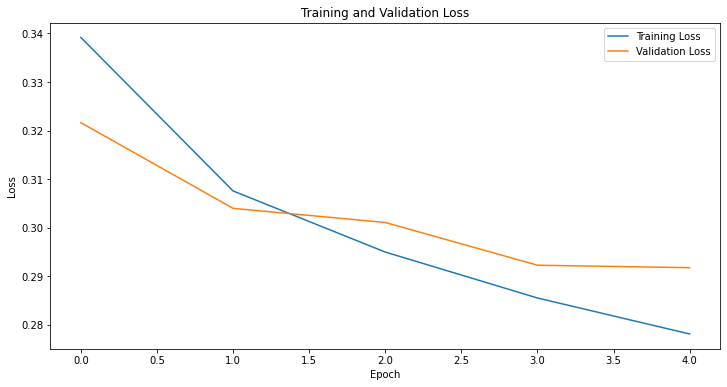

In [10]:
show_result(SBL_history)

- Simple Base Line(이하 SBL)모델도 과소 적합 상태로 5 epoch 학습을 마쳤다.

# STEP 3 : 두 모델의 비교

실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

## 학습 과정 비교

In [20]:
def compare_history(SHG_history, SBL_history):
    plt.figure(figsize=(12, 6))

    # SHG 모델 시각화
    plt.plot([loss / 4 for loss in training_history['loss']], label='SHG Training Loss', color='skyblue', linestyle=':') # 점선 (Training Loss)
    plt.plot([loss / 4 for loss in training_history['val_loss']], label='SHG Validation Loss', color='blue', linestyle='-') # 실선 (Validation Loss)

    # SBL 모델 시각화
    plt.plot(SBL_history['loss'], label='SBL Training Loss', color='lightcoral', linestyle=':') # 점선 (Training Loss)
    plt.plot(SBL_history['val_loss'], label='SBL Validation Loss', color='red', linestyle='-') # 실선 (Validation Loss)

    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

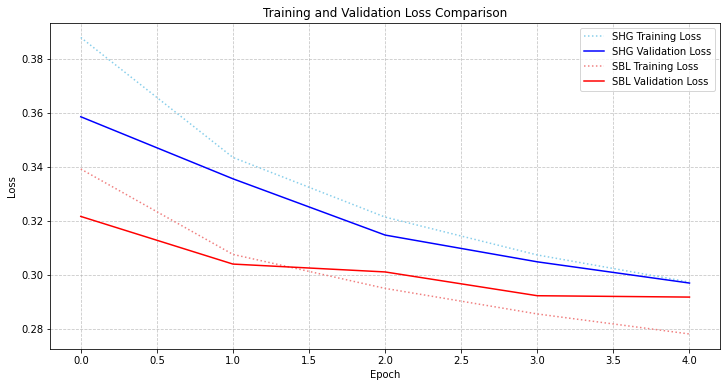

In [21]:
compare_history(training_history, SBL_history)

- Stacked Hourglass (이하 SHG) 모델의 Loss는 4개 출력의 Loss 평균값으로 그래프를 그려보았다.
- SHG 모델이 SBL에 비해 다소 높은 Loss를 기록했지만 감소폭이 크다.
- SHG 모델은 Validation loss가 Training loss에 낮거나 비슷한데 비해, SBL모델은 3 epoch부터 반대의 모습을 보인다.
- 아직 판단하기는 이르지만 해당 지표만 봤을 때는 조금 더 복잡한 모델인 SHG가 일반화 성능이 비교적 좋을 것으로 기대된다.

## Inference 결과 비교

### 비교를 위한 함수 구성

In [18]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

JOINT_NAMES = [
    "R_ANKLE", "R_KNEE", "R_HIP", "L_HIP", "L_KNEE", "L_ANKLE", "PELVIS",
    "THORAX", "UPPER_NECK", "HEAD_TOP", "R_WRIST", "R_ELBOW", "R_SHOULDER",
    "L_SHOULDER", "L_ELBOW", "L_WRIST"]

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]]

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

In [19]:
def show_keypoints_on_image(model, test_image, index=None):
    image, keypoints = predict(model, test_image)
    
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    # 이미지 크기에 맞게 키포인트 좌표 조정을 위한 높이 너비 저장
    image_h, image_w, _ = image.shape
    
    for i, joint in enumerate(keypoints):
        # 특정 키포인트만 보고 싶다면 해당 인덱스만 처리
        if index is not None and index != i:
            continue

        joint_x = joint[0] * image_w
        joint_y = joint[1] * image_h
        
        # 키포인트 점 찍기
        ax.scatter(joint_x, joint_y, s=30, c='red', marker='o', zorder=2)

        # 키포인트 이름 텍스트 추가
        # 키포인트와 겹치지 않게 약간 위치 조정
        text_offset_x = 5
        text_offset_y = 5
        
        ax.text(joint_x + text_offset_x, joint_y + text_offset_y, 
                JOINT_NAMES[i], 
                color='cyan',          # 텍스트 색상
                fontsize=8,            # 폰트 크기
                fontweight='bold',     # 폰트 굵기
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1.5), # 텍스트 배경
                zorder=3)              # 텍스트가 점 위에 오도록 zorder 설정

        # 좌표 출력
        print(f"{i}.{JOINT_NAMES[i]}: ({int(joint_x)}, {int(joint_y)})")

    plt.show()

def compare_model_predictions(image_path, shg_model, sbl_model):
    # 모델별 예측
    original_image, shg_keypoints = predict(shg_model, image_path)
    _, sbl_keypoints = predict(sbl_model, image_path)

    # 시각화 공간 확보
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12)) 

    # 키포인트 결과 비교
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('SHG Model Keypoints', fontsize=12)
    for i, joint in enumerate(shg_keypoints):
        joint_x = joint[0] * original_image.shape[1]
        joint_y = joint[1] * original_image.shape[0]
        axes[0, 0].scatter(joint_x, joint_y, s=30, c='red', marker='o')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(original_image)
    axes[0, 1].set_title('SBL Model Keypoints', fontsize=12)
    for i, joint in enumerate(sbl_keypoints):
        joint_x = joint[0] * original_image.shape[1]
        joint_y = joint[1] * original_image.shape[0]
        axes[0, 1].scatter(joint_x, joint_y, s=30, c='red', marker='o')
    axes[0, 1].axis('off')

    # 스켈레톤 결과 비교
    axes[1, 0].imshow(original_image)
    axes[1, 0].set_title('SHG Model Skeleton', fontsize=12)
    shg_joints_pixel = [(j[0] * original_image.shape[1], j[1] * original_image.shape[0]) for j in shg_keypoints]
    for bone in MPII_BONES:
        joint_1 = shg_joints_pixel[bone[0]]
        joint_2 = shg_joints_pixel[bone[1]]
        axes[1, 0].plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(original_image)
    axes[1, 1].set_title('SBL Model: Skeleton', fontsize=12)
    sbl_joints_pixel = [(j[0] * original_image.shape[1], j[1] * original_image.shape[0]) for j in sbl_keypoints]
    for bone in MPII_BONES:
        joint_1 = sbl_joints_pixel[bone[0]]
        joint_2 = sbl_joints_pixel[bone[1]]
        axes[1, 1].plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

### 비교 모델 준비

In [20]:
SHG_WEIGHTS_PATH = os.path.join(MODEL_PATH, 'SHG_model-epoch-5-loss-1.1878.h5')
SBL_WEIGHTS_PATH = os.path.join(MODEL_PATH, 'SBL-epoch-5-loss-0.2918.h5')

SHG_model = StackedHourglassNetwork()
SHG_model.load_weights(SHG_WEIGHTS_PATH)

SBL_model = Simplebaseline()
SBL_model.load_weights(SBL_WEIGHTS_PATH)

### 각 이미지 별 Inference 결과 시각화 비교

In [10]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

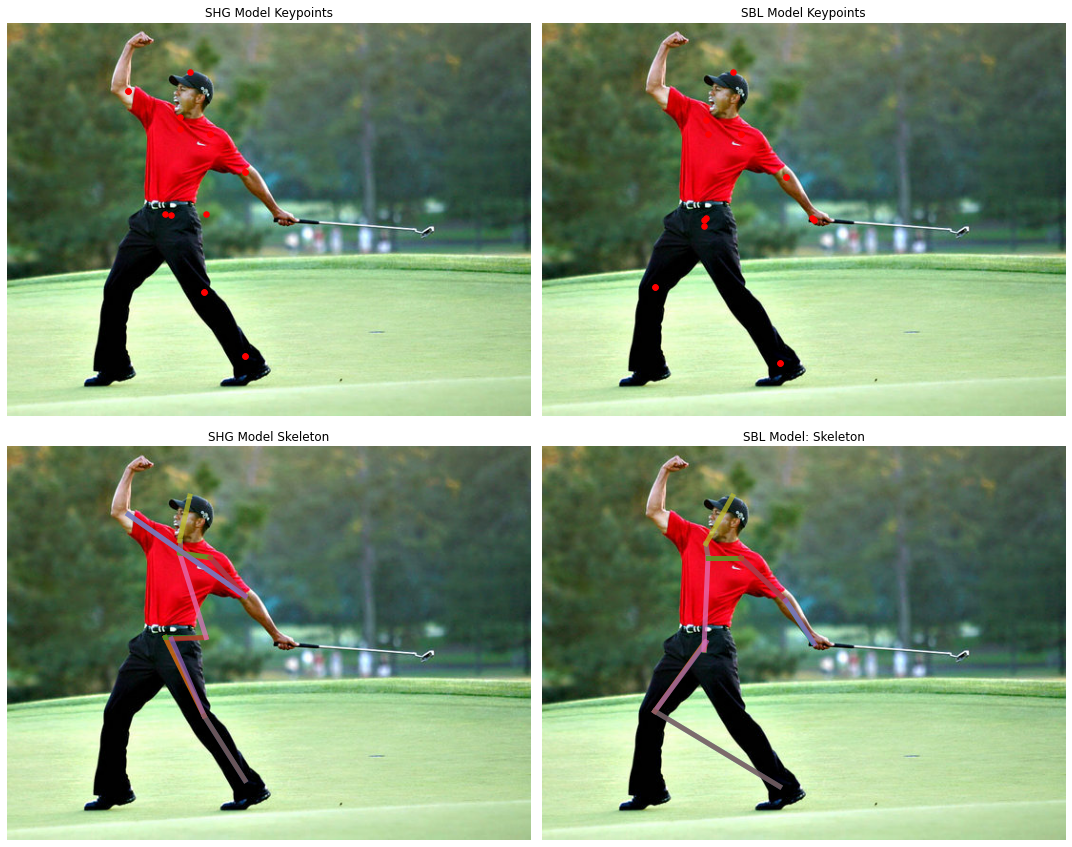

In [11]:
compare_model_predictions(test_image, SHG_model, SBL_model)

- 키 포인트 시각화 결과:
    - SHG의 경우 사람의 신체 부위 밖에 찍힌 Keypoint가 관측되었다. 반면, SBL의 경우는 모든 Keypoint가 신체 위에서 발견된다.

- SHG의 골격 시각화 결과:
    - 골격을 그려보니 왼 다리를 두 다리가 겹쳐진 것으로 인식하였다. (자세히 보아야만 보인다.)
    - 양팔 모두 팔꿈치까지만 인식한 것처럼 보인다.
    - 허리 부분에 기형적인 모습이 관측되었다.
    
- SBL의 골격 시각화 결과:
    - 왼팔은 손목까지 잘 인식하였지만, 왼팔은 보이지 않는다.
    - 오른 무릎과 왼 발목을 하나의 다리로 인식하였다.
    
- 이렇게만 보면 그 인식 결과를 제대로 확인하기에 부족함이 느껴졌다.
    - 한 쪽 팔이나 다리가 보이지 않는 것이 다른 곳과 겹쳐져 있는 경우인지 전혀 인식하지 못한 경우인지 구분이 어렵다.
    - 기형적으로 보이는 부분이 어떤 키포인트를 인식한 결과인지 확인이 어렵다.

- 인식한 키포인트가 정확히 무엇인지, 겹쳐서 안 보이는 부분은 없었는지 확인이 필요해 보인다.

0.R_ANKLE: (249, 350)
1.R_KNEE: (206, 282)
2.R_HIP: (165, 200)
3.L_HIP: (171, 201)
4.L_KNEE: (206, 282)
5.L_ANKLE: (249, 350)
6.PELVIS: (208, 200)
7.THORAX: (180, 111)
8.UPPER_NECK: (180, 98)
9.HEAD_TOP: (191, 51)
10.R_WRIST: (126, 70)
11.R_ELBOW: (249, 156)
12.R_SHOULDER: (212, 116)
13.L_SHOULDER: (212, 116)
14.L_ELBOW: (249, 156)
15.L_WRIST: (126, 70)


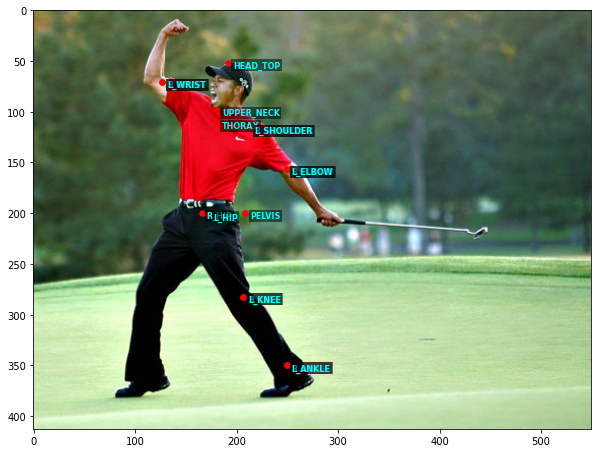

In [12]:
show_keypoints_on_image(SHG_model, test_image)

**SHG의 키포인트 별 네이밍 결과**
- 좌우 발목을 모두 (249, 350)으로 중복 인식하였다.
- 좌우 무릎 역시 (206, 282)으로 같은 지점으로 인식하였다.
- 골반을 신체 부위 밖에서 인식했으며 그 위치가 기형적인 위치이다.
- 좌우 손목을 동일한 위치 (126, 70)로 인식했으며 해당 위치는 실제로 오른쪽 팔꿈치에 해당한다.
- 좌우 팔꿈치를 모두 동일하게 실제 왼쪽 팔꿈치 위치(249, 156)로 인식했다.
- 좌우 어깨 역시 동일한 위치(212, 116)로 인식하였다.
- 16개 키포인트 중 8개 정도(50%)만 적절한 위치로 인식한 것 같다.

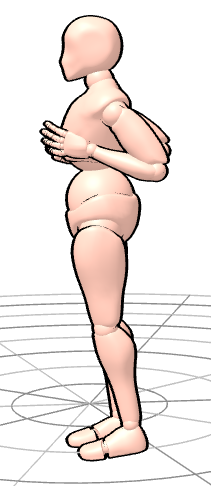

- 해당 정보를 바탕으로 재구성한 포즈 추정 결과

0.R_ANKLE: (249, 356)
1.R_KNEE: (118, 277)
2.R_HIP: (169, 206)
3.L_HIP: (171, 204)
4.L_KNEE: (118, 277)
5.L_ANKLE: (249, 356)
6.PELVIS: (169, 212)
7.THORAX: (174, 116)
8.UPPER_NECK: (171, 101)
9.HEAD_TOP: (199, 51)
10.R_WRIST: (283, 204)
11.R_ELBOW: (255, 161)
12.R_SHOULDER: (208, 116)
13.L_SHOULDER: (208, 116)
14.L_ELBOW: (255, 161)
15.L_WRIST: (285, 206)


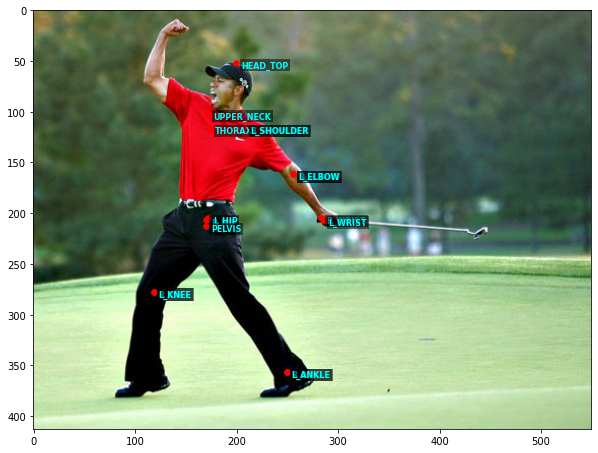

In [13]:
show_keypoints_on_image(SBL_model, test_image)

- 여기서 좌우를 구별하지 않고 동일 지점에서 인식한 결과가 보인다.
    - 좌우 발목, 좌우 무릎, 좌우 팔꿈치, 좌우 어깨
    - 완전히 동일한 지점은 아니지만 거의 같은 지점에서 좌우 손목을 인식했다.
    
- 16개 키포인트 중 10개(62.5%) 정도의 키포인트는 적절한 위치로 인식했다.

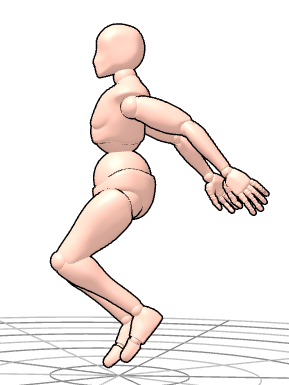

[해당 키포인트 좌표 정보를 기반으로 재구성한 포즈 추정 결과]

**해당 이미지 추론 결과**
1. 두 모델 모두 좌우 신체 부위를 구별하지 못했다.
    - 하나의 무릎을 인식하고 이것이 무릎일 확률이 높다면 좌우를 구분하지 않고 좌측 무릎이기도 하고, 우측 무릎이기도 한 것으로 판단하는 것 같다.
    - 학습과정에서 무릎, 손목, 어깨, 팔꿈치 등의 특징을 학습은 했으나 좌우 구분하는 법을 충분히 학습하지 못하고 종료된 것으로 예상된다.


2. SHG 모델의 추론 결과 중 신체 부위 밖에 키포인트를 예측한 결과가 있었으나 SBL에서는 그렇지 않았다는 점. SHG의 키포인트가 50% 정도만 적절한 반면, SBL은 62.5% 적절한 키포인트를 잡았는 점 등을 미루어 볼 때 SBL이 더 자세 추정을 잘 했다고 볼 수 있다.

이러한 현상이 다른 이미지 및 자세에서도 동일하게 관측되는지 여부를 더 알아봐야겠다.

#### Case 1. 정면, 자연스럽게 서 있는 자세, 한 명

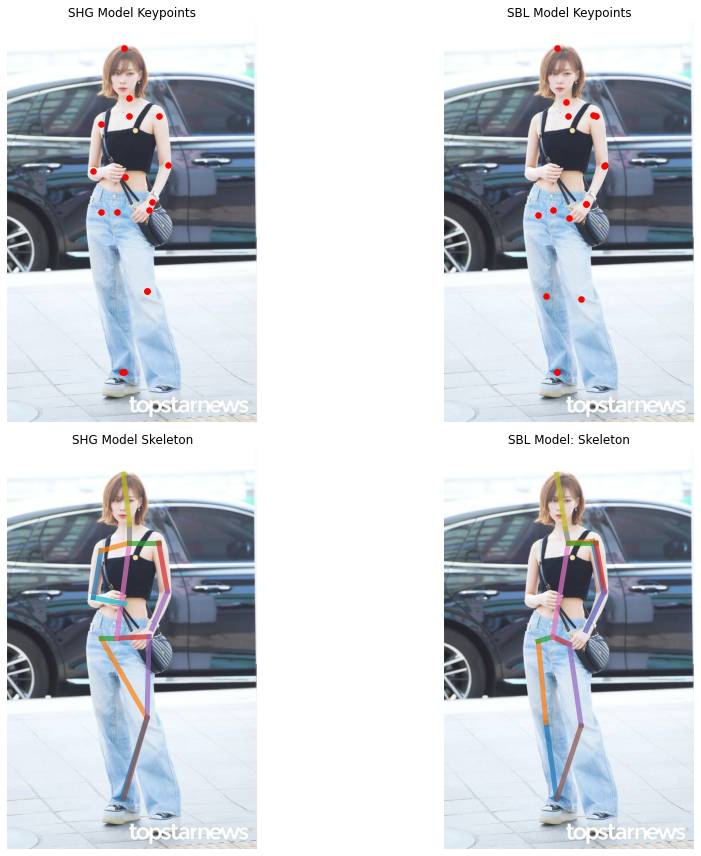

In [21]:
compare_model_predictions('./test_img/standing_front.jpg', SHG_model, SBL_model)

- 가장 추정이 쉬울 것으로 예상한 자세에서도 틀리는 부분이 나왔다.

- SHG의 경우 상반신 좌우 구분을 잘했으나 다리는 좌우를 구분하지 못했다.
- SBL의 경우 무릎은 좌우 구분을 잘했으나 상반신 좌우를 구분하지 못했다.

- 해당 사진 기분으로는 SHG이 비교적 자세 추정을 잘했다.

#### Case 2. 정면, 서 있는 자세, 여러명

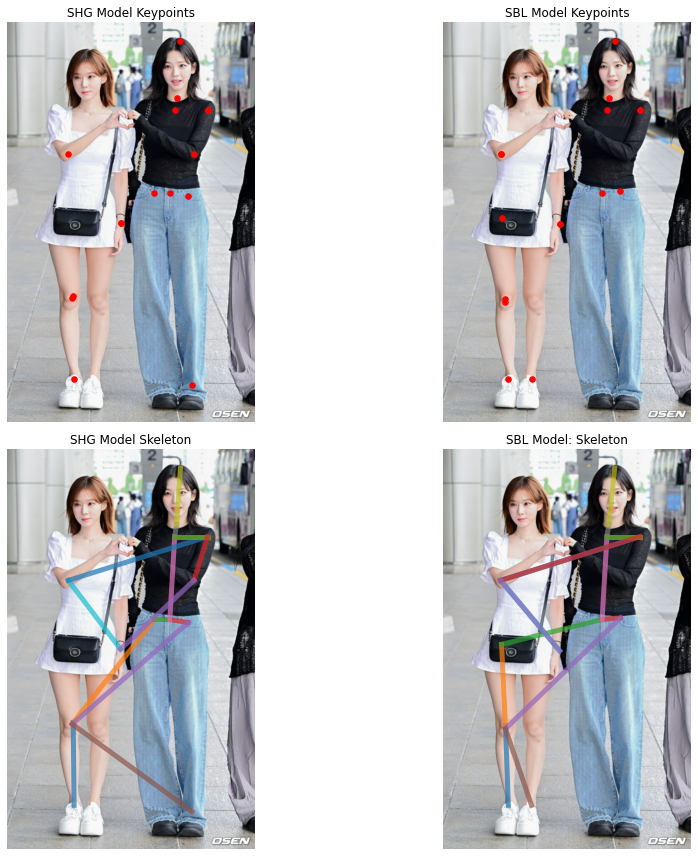

In [23]:
compare_model_predictions('./test_img/standing_front_people.jpg', SHG_model, SBL_model)

- 여러명이 등장하지만 한 명으로 간주하고 키포인트를 출력했다.

0.R_ANKLE: (138, 741)
1.R_KNEE: (136, 568)
2.R_HIP: (305, 354)
3.L_HIP: (376, 360)
4.L_KNEE: (134, 572)
5.L_ANKLE: (384, 754)
6.PELVIS: (337, 354)
7.THORAX: (348, 182)
8.UPPER_NECK: (352, 156)
9.HEAD_TOP: (360, 39)
10.R_WRIST: (235, 416)
11.R_ELBOW: (126, 273)
12.R_SHOULDER: (416, 182)
13.L_SHOULDER: (416, 182)
14.L_ELBOW: (388, 273)
15.L_WRIST: (235, 416)


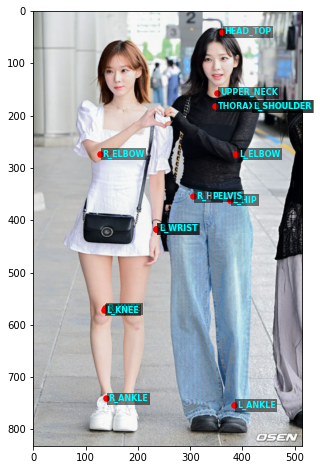

In [24]:
show_keypoints_on_image(SHG_model, './test_img/standing_front_people.jpg')

In [25]:
13 / 32

0.40625

- SHG의 경우:
    - 좌우 어깨, 손목, 무릎을 각각 한 지점으로 추론했다.
    - 두 사람에 대한 키포인트를 다 찾지는 않았지만 나머지 추론 결과는 맞기는 했다.
    - 32개 포인트 중 13개는 적절한 추론이었다. (40.6% 정답률)

0.R_ANKLE: (134, 741)
1.R_KNEE: (128, 575)
2.R_HIP: (120, 406)
3.L_HIP: (368, 351)
4.L_KNEE: (128, 581)
5.L_ANKLE: (183, 741)
6.PELVIS: (329, 354)
7.THORAX: (339, 182)
8.UPPER_NECK: (344, 156)
9.HEAD_TOP: (356, 39)
10.R_WRIST: (241, 419)
11.R_ELBOW: (118, 273)
12.R_SHOULDER: (408, 182)
13.L_SHOULDER: (408, 182)
14.L_ELBOW: (118, 273)
15.L_WRIST: (241, 419)


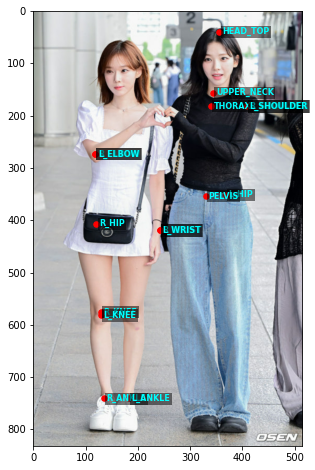

In [26]:
show_keypoints_on_image(SBL_model, './test_img/standing_front_people.jpg')

- SBL의 경우:
    - 좌우 어깨, 손목, 팔꿈치, 무릎, 발목을 각각 한 지점으로 추론했다.
    - 32개 포인트 중 10개는 적절한 추론이었다. (31.3% 정답률)

- 학습 데이터셋 내에 여러명의 인물이 등장하는 이미지가 포함되어 있으므로 이런 경우도 학습을 했을 텐데, 한 명으로 추정하는 것이 혹시 너무 가까이 붙어 있어서는 아닌지 의심되어 거리를 두고 서 있는 다 인원 이미지로 테스트 해봤다.

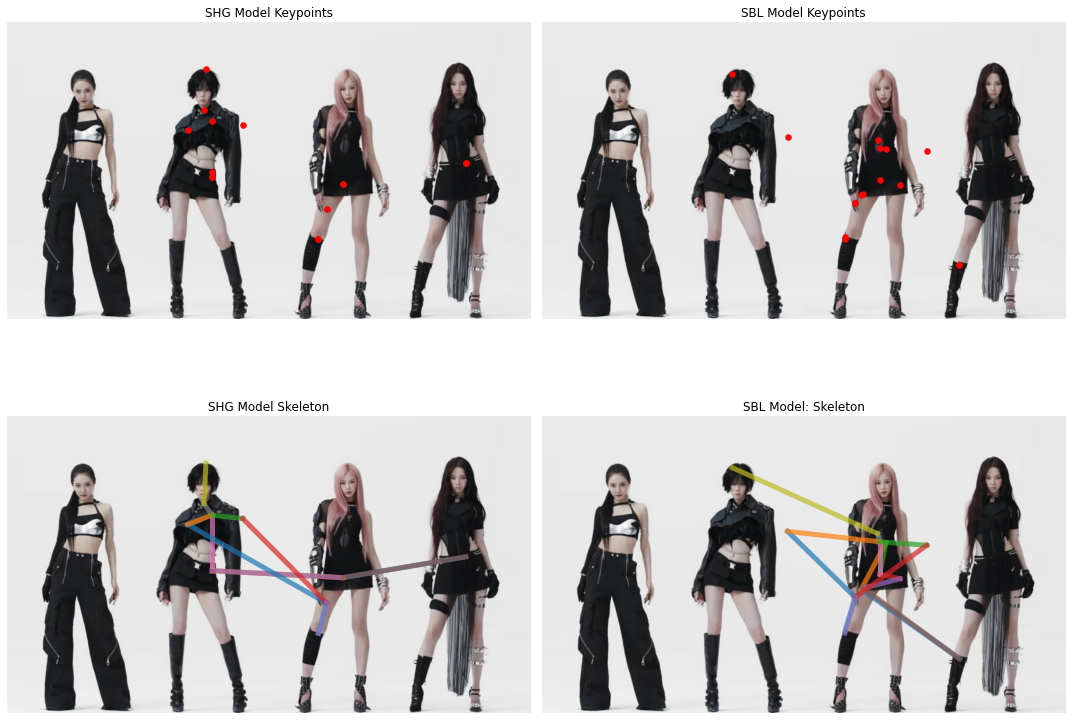

In [28]:
compare_model_predictions('./test_img/standing_front_4people.jpg', SHG_model, SBL_model)

- 이번에도 두 모델 모두 한 사람이라고 가정하고 키포인트를 찾아냈다.

#### Case 3. 회전

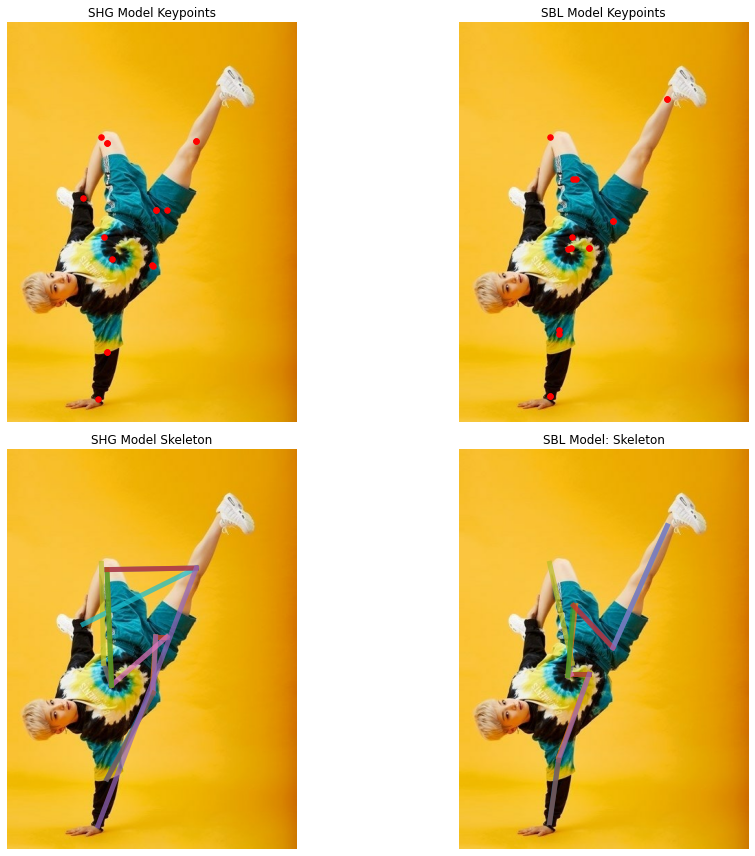

In [29]:
compare_model_predictions('./test_img/rotated.jpg', SHG_model, SBL_model)

0.R_ANKLE: (145, 480)
1.R_KNEE: (211, 352)
2.R_HIP: (215, 273)
3.L_HIP: (215, 273)
4.L_KNEE: (212, 355)
5.L_ANKLE: (145, 480)
6.PELVIS: (232, 273)
7.THORAX: (151, 343)
8.UPPER_NECK: (140, 311)
9.HEAD_TOP: (136, 166)
10.R_WRIST: (110, 255)
11.R_ELBOW: (275, 173)
12.R_SHOULDER: (145, 175)
13.L_SHOULDER: (145, 175)
14.L_ELBOW: (275, 173)
15.L_WRIST: (131, 548)


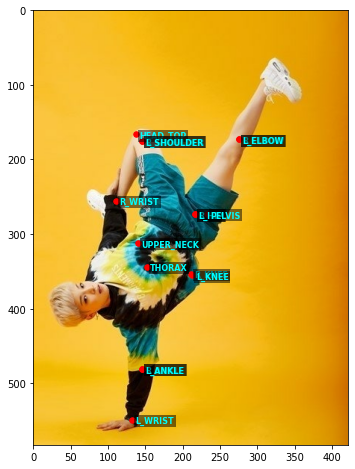

In [30]:
show_keypoints_on_image(SHG_model, './test_img/rotated.jpg')

0.R_ANKLE: (131, 544)
1.R_KNEE: (145, 448)
2.R_HIP: (189, 327)
3.L_HIP: (189, 327)
4.L_KNEE: (145, 453)
5.L_ANKLE: (131, 544)
6.PELVIS: (163, 327)
7.THORAX: (158, 330)
8.UPPER_NECK: (164, 311)
9.HEAD_TOP: (131, 166)
10.R_WRIST: (303, 111)
11.R_ELBOW: (224, 289)
12.R_SHOULDER: (169, 227)
13.L_SHOULDER: (166, 227)
14.L_ELBOW: (224, 289)
15.L_WRIST: (303, 111)


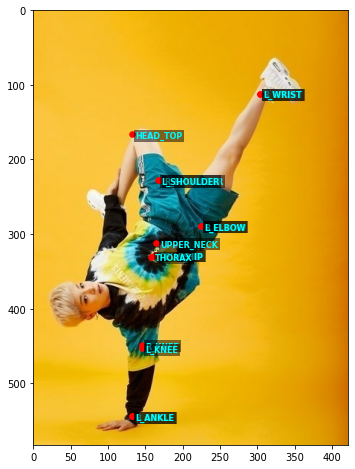

In [31]:
show_keypoints_on_image(SBL_model, './test_img/rotated.jpg')

- 무릎을 팔꿈치 혹은 머리, 어깨 등으로 오인식했다.
- 복부 부분을 목과 흉부로 오인식했다.
- 옆구리를 무릎으로 오인식했다.
- 학습 데이터가 주로 상반신이 위, 하반신이 아래인 이미지이기 때문에 어려울 것으로 예상은 했다. 그러나 각 키 포인트 위치의 관계를 보면 전혀 불가능한 자세가 나왔다.
- 이런 경우를 대비하여 데이터 증강에서 회전이나 상하 반전 등의 적용이 필요해 보인다.

#### Case 4. 가려진 신체 일부

4-1. 오른쪽 팔이 상당 부분 옷으로 가려져 있고, 다리가 교차하여 왼쪽 발목이 가려져 있는 사진.

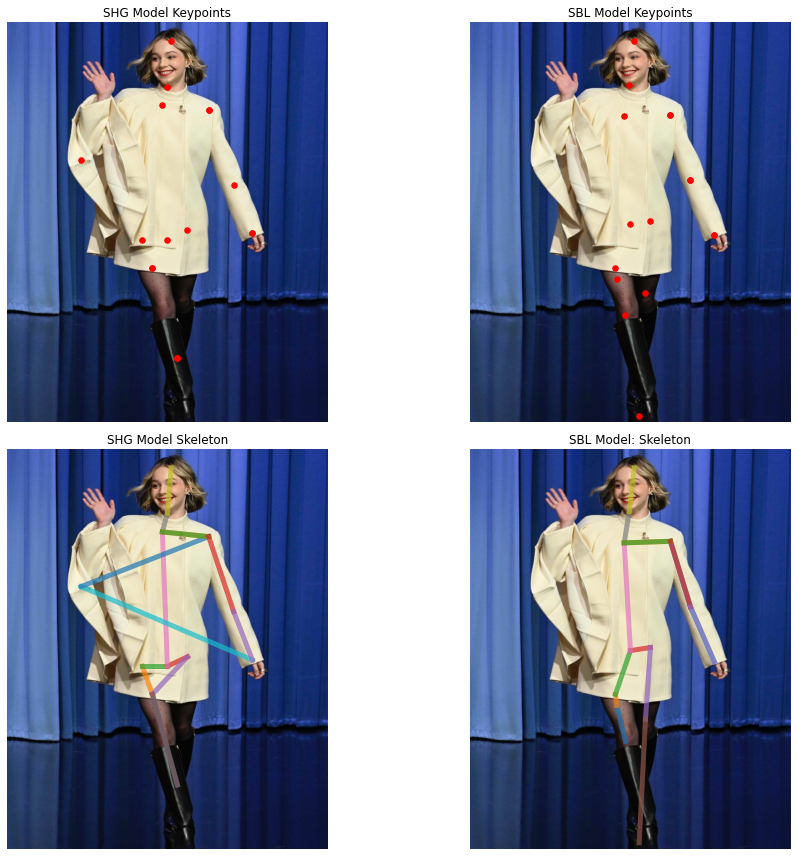

In [33]:
compare_model_predictions('./test_img/occluded01.jpg', SHG_model, SBL_model)

- 선으로 그어진 모습을 보면 한 눈에 SBL 모델이 더 나은 결과를 보인 것처럼 보인다.

0.R_ANKLE: (573, 1132)
1.R_KNEE: (489, 827)
2.R_HIP: (455, 732)
3.L_HIP: (607, 700)
4.L_KNEE: (489, 827)
5.L_ANKLE: (573, 1132)
6.PELVIS: (540, 732)
7.THORAX: (523, 279)
8.UPPER_NECK: (540, 216)
9.HEAD_TOP: (552, 63)
10.R_WRIST: (826, 711)
11.R_ELBOW: (248, 463)
12.R_SHOULDER: (679, 295)
13.L_SHOULDER: (679, 295)
14.L_ELBOW: (763, 548)
15.L_WRIST: (826, 711)


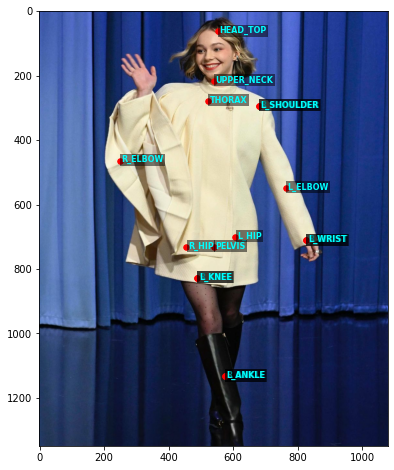

In [34]:
show_keypoints_on_image(SHG_model, './test_img/occluded01.jpg')

- SHG의 경우:
    - 못 맞출 것이라고 예상한 오른쪽 팔꿈치를 맞춤.
    - 그런데 오히려 오른쪽 손목을 인지하지 못했다. (우측 손목과 동일한 위치로 예측)
    - 허벅지 중앙을 무릎으로 예상하고 정강지 부분을 발목으로 예상하는 등 오인식이 많았다.

0.R_ANKLE: (523, 985)
1.R_KNEE: (493, 864)
2.R_HIP: (489, 827)
3.L_HIP: (607, 669)
4.L_KNEE: (590, 911)
5.L_ANKLE: (569, 1327)
6.PELVIS: (540, 679)
7.THORAX: (518, 316)
8.UPPER_NECK: (535, 210)
9.HEAD_TOP: (552, 63)
10.R_WRIST: (822, 716)
11.R_ELBOW: (742, 532)
12.R_SHOULDER: (675, 310)
13.L_SHOULDER: (675, 310)
14.L_ELBOW: (742, 532)
15.L_WRIST: (822, 716)


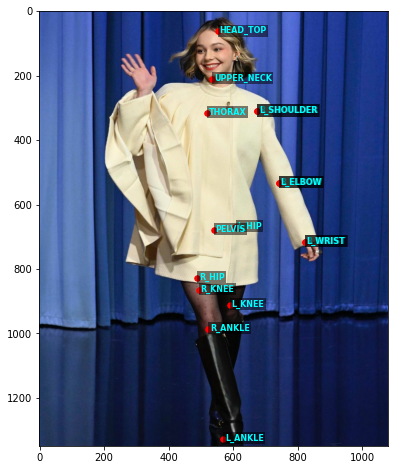

In [35]:
show_keypoints_on_image(SBL_model, './test_img/occluded01.jpg')

- SBL의 경우:
    - 예상대로 상반신 우측 부분을 맞추지 못하고 좌측 부분과 동일한 곳으로 인식했다.
    - 발목 부분도 다른 곳으로 오인식했다.
    - 가려진 부분을 제외 나머지 부분은 제대로 인식해냈다.

4-2. 몸으로 가려져 전혀 보이지 않는 상반신 우측

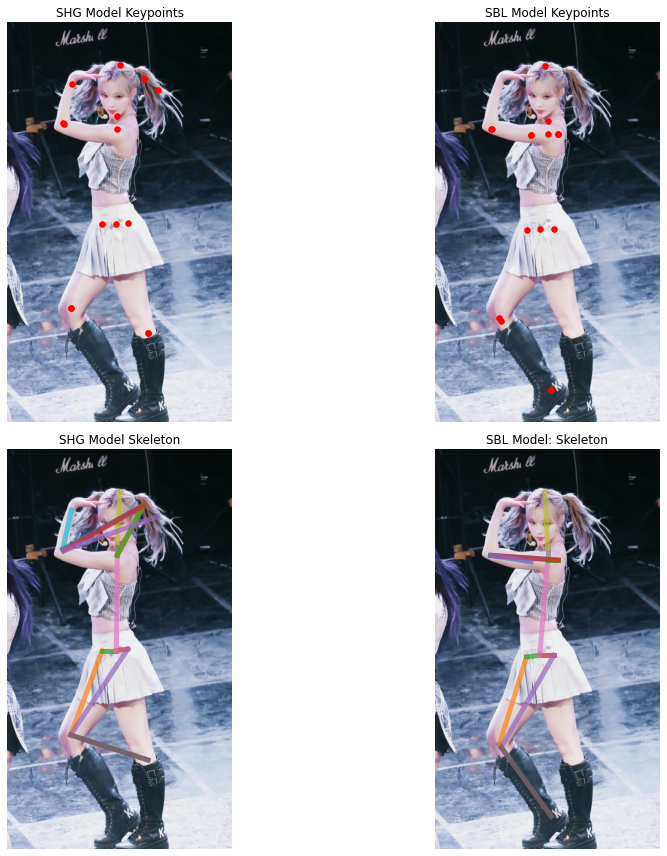

In [36]:
compare_model_predictions('./test_img/occluded02.jpg', SHG_model, SBL_model)

- 보이는 것도 잘 못 찾는데 안 보이는 것은 너무도 당연하게 예측해내지 못한다.

0.R_ANKLE: (292, 646)
1.R_KNEE: (131, 594)
2.R_HIP: (197, 419)
3.L_HIP: (250, 416)
4.L_KNEE: (131, 594)
5.L_ANKLE: (292, 646)
6.PELVIS: (226, 419)
7.THORAX: (228, 221)
8.UPPER_NECK: (228, 195)
9.HEAD_TOP: (234, 87)
10.R_WRIST: (133, 126)
11.R_ELBOW: (115, 208)
12.R_SHOULDER: (283, 117)
13.L_SHOULDER: (283, 117)
14.L_ELBOW: (117, 211)
15.L_WRIST: (312, 139)


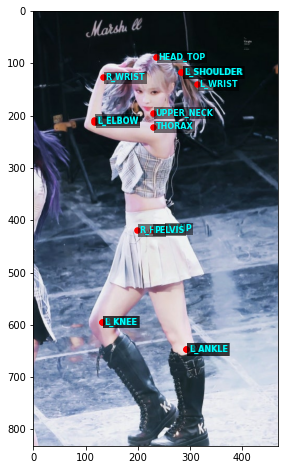

In [37]:
show_keypoints_on_image(SHG_model, './test_img/occluded02.jpg')

- SHG 모델:
    - 보이는 좌측 어깨와 팔꿈치 등을 우측으로 동일한 인식할 것이라 예상했지만 전혀 엉뚱한 곳에 키포인트를 찍었다.
    - 좌측 옆통수를 좌측 어깨와 손목으로 인식하는 등 엉망이다.
    
    - 해당 모델은 부츠를 신은 다리를 인식하지 못하는 경향을 보인다.
        - 허벅지에서 부츠로 바뀌는 경계를 신발의 경계로 인식하는 것 같다. 그래서 부츠 바로 위나 부츠 중앙을 발목으로 추론하는 결과 들을 보였다.

0.R_ANKLE: (241, 763)
1.R_KNEE: (133, 614)
2.R_HIP: (190, 432)
3.L_HIP: (246, 429)
4.L_KNEE: (137, 620)
5.L_ANKLE: (241, 763)
6.PELVIS: (217, 429)
7.THORAX: (234, 230)
8.UPPER_NECK: (234, 204)
9.HEAD_TOP: (228, 91)
10.R_WRIST: (199, 234)
11.R_ELBOW: (115, 221)
12.R_SHOULDER: (255, 230)
13.L_SHOULDER: (255, 230)
14.L_ELBOW: (118, 221)
15.L_WRIST: (199, 234)


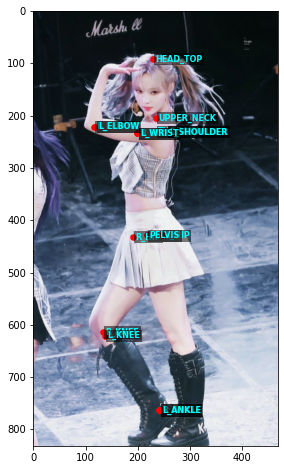

In [38]:
show_keypoints_on_image(SBL_model, './test_img/occluded02.jpg')

- SBL 모델:
    - 손목이 분명 보이는데 어깨 부근으로 오인식했다.
        - 머리카락과 겹치 손목 부분을 제대로 인식하지 못하는 것으로 의심된다.
    - 이번에도 좌우를 잘 구분하지 못했지만 잘 보이는 부분에 대한 인식을 잘 하는 것 같다.

4-3. 몸으로 가려져 보이지 않는 좌측 팔꿈치, 하지만 손목은 보이는데?

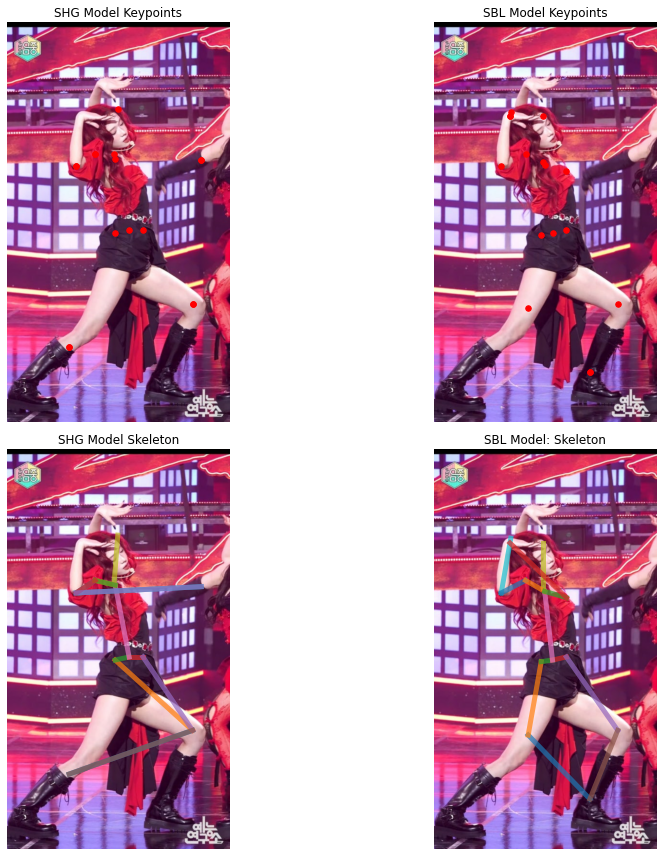

In [42]:
compare_model_predictions('./test_img/occluded03.jpg', SHG_model, SBL_model)

- SHG가 주로 기형적이거나 불가능한 자세로 잘 못 추정해 내는 모습이 자꾸 등장한다.
- SBL은 좌우 구분을 못해서 그렇지 가능한 자세로 추정하기는 하는 것 같다.

0.R_ANKLE: (128, 676)
1.R_KNEE: (385, 585)
2.R_HIP: (224, 438)
3.L_HIP: (282, 432)
4.L_KNEE: (385, 585)
5.L_ANKLE: (128, 676)
6.PELVIS: (253, 432)
7.THORAX: (224, 282)
8.UPPER_NECK: (222, 273)
9.HEAD_TOP: (229, 178)
10.R_WRIST: (403, 286)
11.R_ELBOW: (142, 299)
12.R_SHOULDER: (182, 273)
13.L_SHOULDER: (182, 273)
14.L_ELBOW: (142, 299)
15.L_WRIST: (403, 286)


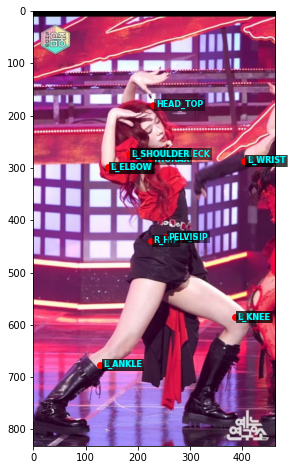

In [41]:
show_keypoints_on_image(SHG_model, './test_img/occluded03.jpg')

- 역시 부츠 바로 윗 부분(무릎)을 발목으로 인식했다.

### 시각화 비교 결과

- 두 모델 모두 좌우 구분을 잘 못하지만 그나마 SHG모델은 어느 정도 구분해내는 편이다.

- 두 모델 모두 이미지 내에서 한 명 밖에 인지하지 못한다.
    - Detection 모델로 크롭한 이미지 내에서 KeyPoint를 찾는 2 stage 방식을 고려해 봐야 겠다.

- SHG 모델은 다리에서 색상이나 경계선 등을 기준으로 발목을 구분하는 경향이 있다.
    - 부츠 윗 부분 무릎을 반복적으로 발목이라고 오인식하는 사례를 관측했다.

- SHG 모델은 위치와 거리상 불가능한 자세를 추정 결과로 출력하기도 한다.
    - 편견없이 그런 결과를 내는 걸 보면 복잡한 모델의 구조 등으로 인해 특정 특성에 대한 편향성을 줄이는 효과를 받은 것 같다.
    - 이는 학습 상황에서 일반화 성능을 끌어올리는 효과를 기대할 수 있겠지만 5 epoch라는 과소 적합 상태에서는 오히려 괴상한 자세를 추정하는 효과를 보인 것 같다.

- SBL 모델은 좌우를 구분하지 못하는 경우가 많지만, 좌우 구분 없이 각 포인트를 비교적 잘 잡아내는 특징을 보였다.

기준에 따라 어느 모델이 우월하다는 판단이 달라지겠지만, 좌우를 제외하고 각 키포인트에 대해 비교적 잘 예측이 가능한 SBL이 실용성이 더 높다고 할 수 있겠다.

## Heatmap에 대한 Mean Squared Error 비교

모델이 예측한 히트맵과 실제 히트맵 간의 픽셀별 **평균 제곱 오차(Mean Squared Error)**

In [55]:
val_dataset = create_dataset(val_tfrecords, 16, 16, is_train=False)
val_dataset

<PrefetchDataset shapes: ((None, 256, 256, None), (None, 64, 64, 16)), types: (tf.float32, tf.float32)>

In [60]:
def calculate_heatmap_mse(model, val_dataset):
    """
    모델의 예측 히트맵과 실제(Ground Truth) 히트맵 간의 평균 MSE를 계산합니다.
    
    Args:
        model (tf.keras.Model): 자세 추정 모델.
        val_dataset (tf.data.Dataset): 검증 데이터셋 (image, heatmaps만 반환).
        
    Returns:
        float: 전체 히트맵에 대한 평균 MSE 값.
    """
    
    total_mse = 0.0
    num_batches = 0
    
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    for batch_idx, (batch_images, batch_gt_heatmaps) in enumerate(val_dataset):
        # 모델 예측
        batch_predicted_heatmaps = model(batch_images, training=False)
        
        # 모델의 출력이 여러개인 경우 마지막 출력을 사용
        if type(batch_predicted_heatmaps) != list:
            batch_predicted_heatmaps = [batch_predicted_heatmaps]
        
        batch_predicted_heatmaps = batch_predicted_heatmaps[-1] # 최종 히트맵

        # MSE 계산        
        current_batch_mse = loss_fn(batch_gt_heatmaps, batch_predicted_heatmaps).numpy()
        
        total_mse += current_batch_mse
        num_batches += 1

    # 최종 평균 MSE 계산
    if num_batches == 0:
        return 0.0
    
    average_mse = total_mse / num_batches
    return average_mse

In [61]:
SHG_MSE = calculate_heatmap_mse(SHG_model, val_dataset)
SBL_MSE = calculate_heatmap_mse(SBL_model, val_dataset)

print(f"Stacked Hourglass 모델의 MSE: {SHG_MSE}")
print(f"Simple Baseline 모델의 MSE: {SBL_MSE}")

Stacked Hourglass 모델의 MSE: 0.21033829966106932
Simple Baseline 모델의 MSE: 0.20672011745942606


In [63]:
print(f"SBL 모델이 약{SHG_MSE-SBL_MSE:.4f}정도 낮은 에러율을 보인다.")

SBL 모델이 약0.0036정도 낮은 에러율을 보인다.


# 결론

- 히트맵 MSE와 여러 이미지에서 시각화 결과를 미루어 볼 때, SBL 모델이 SHG 모델에 비해 비교적 나은 결과를 보이는 것을 확인할 수 있었다.

- 아무래도 모델 구조가 복잡한 SHG 모델이 간단한 구조의 SBL 모델과 동일한 데이터, 동일한 epoch를 학습하는 경우 최적화의 어려움이 있었던 것으로 보인다.
    - 두 모델 모두 최적화에 이르지는 못했지만, SHG 모델의 최적화 시점이 더 나중일 것으로 예상되는 상황에서 동일한 Epoch는 공정한 비교는 아니었을 것이다.
    
- 다만, SBL의 간단한 구조와 굉장히 적다고 할 수 있는 5 epoch만으로 학습한 결과, 각 키포인트를 어느 정도 인식하는 모습으로 미루어 볼 때, 해당 Task에서 SBL 모델만으로도 충분히 신속하게(적은 epoch로) 일정 이상 성능을 뽑아낼 수 있을 것으로 보인다.

- 즉, SHG 모델은 해당 데이터를 통해 학습하여 16개의 키포인트를 예측하는 Task를 수행하기에는 다음과 같은 여러 단점을 지닌다.
    - 최적화에 이르는 비용(학습 시간 등)이 비교적 많이 든다.
    - 최적화를 이루더라도 큰 성능 차이를 기대하기 어렵다.
    - 즉, 해당 Task에는 다소 Over qualified 모델 구조라고 할 수 있다.
    
- 해당 데이터를 통해 16개 키포인트를 예측하는 모델을 만들기 위해서는 Stacked hourglass 모델 구조보다는 Simple Baseline 모델 구조를 차용하여 구성하는 것이 다음과 같은 여러 이점을 갖을 것으로 보인다.
    - 보다 적은 비용(학습 시간 및 튜닝 과정)으로 최적화 모델을 구성할 수 있다.
    - 해당 Taskp에서 필요한 충분한 성능이 기대된다.
    - 비교적 간단한 구조이기에 추론 속도가 보다 빠를 것으로 기대된다.

# 회고

- 모델 최적화를 진행할 시간적 여유가 없어서 불완전한 모델로 비교를 진행하여 아쉬움이 크다.

- 굉장히 간단하게 구현한 Simple Baseline 모델이 충분한 성능을 보이는 모습을 확인하여 재미있는 실험이었다.

- 때로는 간단하게 구성한 baseline 모델이 이후 성능 개선을 위해 애쓴 모델보다 적합한 경우가 있을 수 있겠다는 교훈을 얻었다.